**MLaaS Human Activity Recognisation**
---

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df= pd.read_csv("/content/drive/My Drive/Early Drift Detection/pamap2_final.csv")
df

Mounted at /content/drive


,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,activity,accelerometer_x_mean,accelerometer_x_std,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,49,2.021410,9.35812,3.04082,0.431367,-0.015620,-0.035577,2,2.149858,0.125227,...,0.031028,0.065358,-0.068942,1.547971,-0.009330,0.030435,0.017855,0.056646,-0.081657,1.185657
1,50,2.058940,9.31989,3.04151,0.338133,-0.016064,0.007478,2,2.148545,0.125828,...,0.028083,0.065358,-0.068942,1.539219,-0.008860,0.030509,0.015752,0.056646,-0.081657,1.177122
2,51,2.056530,9.16780,3.00350,0.304415,-0.051594,0.014247,2,2.142910,0.123493,...,0.028870,0.065358,-0.068942,1.579466,-0.008765,0.030574,0.016262,0.056646,-0.081657,1.181885
3,52,2.130510,9.12894,2.96625,0.267546,-0.024152,-0.027965,2,2.140975,0.122912,...,0.028597,0.065358,-0.068942,1.586518,-0.009189,0.030690,0.017087,0.056646,-0.081657,1.203080
4,53,2.056530,9.16780,3.00350,0.254874,0.011192,-0.042030,2,2.138305,0.123267,...,0.029001,0.065358,-0.068942,1.590529,-0.010143,0.030953,0.020325,0.056646,-0.081657,1.239417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746350,876674,0.489770,2.82383,9.23639,-0.017195,0.006944,0.007758,4,0.555574,0.179076,...,0.020872,0.098473,-0.038071,1.524133,0.010320,0.029036,0.017445,0.071230,-0.052905,1.307806
746351,876675,0.370253,2.70955,9.08103,-0.032333,-0.044224,0.011758,4,0.547796,0.178511,...,0.020872,0.098473,-0.044224,1.565673,0.011493,0.027862,0.017127,0.071230,-0.052905,1.272671
746352,876676,0.644139,2.70986,9.35454,-0.004483,-0.001148,0.039415,4,0.545582,0.176606,...,0.020872,0.098473,-0.044224,1.560528,0.012877,0.027494,0.017085,0.071230,-0.052905,1.282298
746353,876677,0.566153,2.74771,9.27627,-0.022839,0.045628,0.049042,4,0.545481,0.176592,...,0.020872,0.098473,-0.044224,1.575995,0.014334,0.027442,0.016784,0.071230,-0.052905,1.307547


In [ ]:
df['activity'].value_counts()

,count
activity,
1,186706
2,183461
3,161942
0,142834
4,71412


In [ ]:
activity_col = 'activity'   # adjust to your column name
total_samples = 300_000
# number of classes
n_classes = df[activity_col].nunique()
# number per class
samples_per_class = total_samples // n_classes  # 2,000 per class
# sample equally from each activity
balanced_df = (
    df.groupby(activity_col, group_keys=False)
      .apply(lambda x: x.sample(samples_per_class, random_state=42))
)
# check
print(balanced_df[activity_col].value_counts())
balanced_df.to_csv("balanced_10k.csv", index=False)

/tmp/ipython-input-674122431.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(samples_per_class, random_state=42))


activity
0    60000
1    60000
2    60000
3    60000
4    60000
Name: count, dtype: int64


In [ ]:
balanced_df['activity'].value_counts()

,count
activity,
0,60000
1,60000
2,60000
3,60000
4,60000


**Shuffe samples**

In [ ]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Check counts
print(balanced_df[activity_col].value_counts())

activity
0    60000
1    60000
4    60000
2    60000
3    60000
Name: count, dtype: int64


In [ ]:
df=balanced_df

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
# Step 1: Normalize activity labels to 0-based classes
unique_labels = sorted(df['activity'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
df['activity'] = df['activity'].map(label_map)
# Step 2: Select features and target
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
# Step 3: Train-test split
X = df[features].values
y = df[target].values
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
num_classes = len(unique_labels)
y_cat = to_categorical(y, num_classes)
#joblib.dump(label_encoder, 'label_encoder.pkl')
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
# Step 4: Build CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(len(features), 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Step 5: Train
model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=64)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.8845 - loss: 0.3760 - val_accuracy: 0.9224 - val_loss: 0.2267
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9212 - loss: 0.2362 - val_accuracy: 0.9351 - val_loss: 0.1928
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9336 - loss: 0.1961 - val_accuracy: 0.9462 - val_loss: 0.1583
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9424 - loss: 0.1684 - val_accuracy: 0.9534 - val_loss: 0.1381
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9477 - loss: 0.1487 - val_accuracy: 0.9591 - val_loss: 0.1136


**Concept Drift Setup**
---

In [ ]:
X_test.shape

(60000, 42, 1)

In [ ]:
X_test = X_test.reshape(-1, len(features))
X_test

array([[-0.06215054, -0.30151181,  0.72023266, ..., -0.51811631,
         0.56656361, -0.69324192],
       [ 0.11542841,  0.15179094, -1.75567856, ...,  0.37648768,
         0.37398886,  0.06776205],
       [ 0.90375528, -0.5418309 ,  2.09722015, ..., -0.13435605,
         0.45433112, -0.42130516],
       ...,
       [-0.31933275, -0.0419039 ,  0.22737699, ..., -0.72152312,
         0.64869895, -0.80293095],
       [ 0.22952734, -0.39014806,  0.99848031, ..., -0.60797928,
         0.56507281, -0.7105944 ],
       [ 0.60812031,  0.17991289,  1.05969319, ..., -0.67608674,
         0.66382755, -0.78654766]])

In [ ]:
y_test

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
import pandas as pd
import numpy as np

# Your array (example: X)
# X = np.array([...])  # already exists in your case

# Column names
columns = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
           'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
           'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
           'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
           'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
           'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
           'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
           'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
           'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
           'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
           'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
           'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
           'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
           'gyroscope_z_min', 'gyroscope_z_sma']

# Convert to DataFrame
X_test = pd.DataFrame(X_test, columns=columns)
X_test

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,-0.514715,-0.416326,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,-0.490723,0.579645,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,0.170823,-0.074923,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.582095,1.413927,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,-0.677682,-0.675843,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,-0.684320,-0.681584,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,-0.507788,-0.107334,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,-0.682689,-0.689261,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,-0.482139,-0.503012,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594


In [ ]:
import numpy as np
import pandas as pd
# Step 1: Reload original data
XTest = X_test.copy()
activity_labels = np.argmax(y_test, axis=1)
# Add to XTest DataFrame
XTest['activity'] = activity_labels

In [ ]:
XTest['activity'].value_counts()

,count
activity,
2,12080
3,12041
1,12014
0,11963
4,11902


In [ ]:
XTest.columns

Index(['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma', 'activity'],
      dtype='object')

In [ ]:
XTest.to_csv("drift.csv", index=False)

**Bullet points:**
*   **Original Dataset (O)**: Original HAR dataset without any modifications. Used as the baseline signature to compare against all drifted scenarios
*   **Abrupt Drift (A)**: Sudden and complete change in both feature distribution and activity labels within specific segments as the baseline signature to compare against all drifted scenarios.
* **Incremental Drift (I)**: Stepwise introduction of new concepts or activity patterns, changing a small portion of the data at a time. Mimics slowly evolving contexts, e.g., incremental addition of new user behaviors or devices.
* **Recurrent Drift (R)**: Alternating between original and altered concepts in different segments, returning periodically to previous states. Captures recurring patterns where earlier conditions reappear, such as daily routines or repeated sensor contexts.

In [ ]:
import pandas as pd
import numpy as np

# ---------- IO ----------
def load_data(path):
    """Load dataset with features and label in last column."""
    df = pd.read_csv(path)
    X = df.iloc[:, :-1].copy()
    y = df.iloc[:, -1].copy()
    return X, y

def _return_with_label_last(X_new, y_new):
    out = X_new.copy()
    out[y_new.name] = y_new.values
    return out

# ---------- SUDDEN DRIFT — TYPE 1 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type1_delayed_abrupt(
    X, y,
    *, clean_samples=5000,        # <<< FIXED: Absolute number of clean samples
    corruption_samples=None,      # <<< FIXED: Absolute number of corrupted samples
    corruption_rate=1.0, shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    clean_samples: Number of samples to keep clean from the start
    corruption_samples: Number of samples to corrupt after clean_samples (default: all remaining)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate corruption range
    start_corrupt = clean_samples
    if corruption_samples is None:
        end_corrupt = n  # Corrupt all remaining samples
    else:
        end_corrupt = min(n, start_corrupt + corruption_samples)

    if start_corrupt < n:
        tail_idx = np.arange(start_corrupt, end_corrupt)
        if corruption_rate >= 1.0:
            sel_idx = tail_idx
        else:
            mask = rng.random(len(tail_idx)) < float(corruption_rate)
            sel_idx = tail_idx[mask]

        if len(sel_idx) > 0:
            # STRONG label corruption for specified samples
            for idx in sel_idx:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # STRONG feature corruption for specified samples
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[sel_idx].values
                        # Massive corruption: large noise + mean shift
                        noise = rng.normal(0, 5 * original_vals.std(), len(sel_idx))
                        shift = 4 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[sel_idx] = original_vals + noise + shift
                    else:
                        # Complete categorical scrambling
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=len(sel_idx), replace=True)
                        X_new[col].iloc[sel_idx] = new_vals

    print(f"SUDDEN TYPE 1 FIXED: First {start_corrupt} samples CLEAN -> Samples {start_corrupt} to {end_corrupt} STRONGLY CORRUPTED")
    return _return_with_label_last(X_new, y_new)

# ---------- SUDDEN DRIFT — TYPE 2 (USING ABSOLUTE SAMPLE COUNTS) ----------
def sudden_drift_type2_abrupt_then_recover(
    X, y,
    *, corrupt_samples=5000,      # <<< FIXED: Absolute number of corrupted samples
    recovery_samples=5000,        # <<< FIXED: Absolute number of recovery samples
    start_rate=1.0, end_rate=0.0,
    decay_shape=0.7,
    shuffle_X=True, random_state=None
):
    """
    FIXED: Uses ABSOLUTE sample counts instead of percentages
    corrupt_samples: Number of samples to fully corrupt from the start
    recovery_samples: Number of samples for gradual recovery phase
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    # Calculate ranges using absolute counts
    corrupt_end = min(n, corrupt_samples)
    recovery_end = min(n, corrupt_end + recovery_samples)

    # Build per-index corruption probability vector
    p = np.zeros(n, dtype=float)

    # 1) INITIAL CORRUPTION: First X samples fully corrupted
    if corrupt_end > 0:
        p[:corrupt_end] = float(start_rate)

    # 2) GRADUAL RECOVERY: Next Y samples gradual recovery
    if recovery_end > corrupt_end:
        recovery_length = recovery_end - corrupt_end
        t = np.linspace(0.0, 1.0, recovery_length, endpoint=True)
        # Gradual decay from full corruption to clean
        p[corrupt_end:recovery_end] = end_rate + (start_rate - end_rate) * (1.0 - t**decay_shape)

    # 3) REMAINING SAMPLES: Clean (p=0)

    # Sample indices to corrupt by probability p
    mask = rng.random(n) < p
    sel_idx = np.where(mask)[0]

    if len(sel_idx) > 0:
        # Apply corruption based on probability
        for idx in sel_idx:
            true_class = y_new.iloc[idx]
            wrong_classes = [c for c in classes if c != true_class]
            if wrong_classes:
                y_new.iloc[idx] = rng.choice(wrong_classes)

        # Feature corruption intensity based on corruption probability
        if shuffle_X:
            for col in X.columns:
                if X[col].dtype in ['float64', 'int64']:
                    for idx in sel_idx:
                        corruption_strength = p[idx]  # Strength based on position
                        original_val = X_new[col].iloc[idx]
                        noise = rng.normal(0, 4 * corruption_strength * X[col].std())
                        shift = 3 * corruption_strength * X[col].std() * rng.choice([-1, 1])
                        X_new[col].iloc[idx] = original_val + noise + shift
                else:
                    # For categorical features in fully corrupted region
                    if idx < corrupt_end:
                        unique_vals = X[col].unique()
                        new_val = rng.choice(unique_vals)
                        X_new[col].iloc[idx] = new_val

    print(f"SUDDEN TYPE 2 FIXED: First {corrupt_end} samples CORRUPTED -> Next {recovery_length} samples GRADUAL RECOVERY -> Last {n-recovery_end} samples CLEAN")
    return _return_with_label_last(X_new, y_new)

# ---------- RECURRENT DRIFT (USING ABSOLUTE SAMPLE COUNTS) ----------
def recurrent_drift(X, y, segment_samples=400, *, shuffle_X=True, random_state=None):
    """
    FIXED: Uses absolute sample count for segment size
    segment_samples: Number of samples in each segment (clean/corrupt alternate)
    """
    rng = np.random.default_rng(random_state)
    n = len(y)
    n_segments = (n + segment_samples - 1) // segment_samples
    X_new, y_new = X.copy(), y.copy()
    classes = y.unique()

    for i in range(n_segments):
        s = i * segment_samples
        e = min((i + 1) * segment_samples, n)

        if i % 2 == 1:  # CORRUPTED BLOCK
            # High percentage label corruption
            corrupt_indices = rng.choice(np.arange(s, e), size=int(0.85 * (e-s)), replace=False)
            for idx in corrupt_indices:
                true_class = y_new.iloc[idx]
                wrong_classes = [c for c in classes if c != true_class]
                if wrong_classes:
                    y_new.iloc[idx] = rng.choice(wrong_classes)

            # Strong feature corruption
            if shuffle_X:
                for col in X.columns:
                    if X[col].dtype in ['float64', 'int64']:
                        original_vals = X_new[col].iloc[s:e].values
                        noise = rng.normal(0, 6 * original_vals.std(), e-s)
                        shift = 5 * original_vals.std() * rng.choice([-1, 1])
                        X_new[col].iloc[s:e] = original_vals + noise + shift
                    else:
                        unique_vals = X[col].unique()
                        new_vals = rng.choice(unique_vals, size=(e-s), replace=True)
                        X_new[col].iloc[s:e] = new_vals

            print(f"RECURRENT: Segment {i} ({s}-{e}) CORRUPTED")

        else:  # CLEAN BLOCK
            # Leave completely unchanged for perfect accuracy
            X_new.iloc[s:e] = X.iloc[s:e].to_numpy(copy=True)
            y_new.iloc[s:e] = y.iloc[s:e].to_numpy(copy=True)
            print(f"RECURRENT: Segment {i} ({s}-{e}) CLEAN")

    return _return_with_label_last(X_new, y_new)

# ---------- USAGE ----------
if __name__ == "__main__":
    file_path = "drift.csv"
    X, y = load_data(file_path)
    n_total = len(y)
    print(f"Total samples: {n_total}")

    # pristine
    df_nodrift = _return_with_label_last(X, y)
    df_nodrift.to_csv("har_no_drift.csv", index=False)

    # Sudden Type 1: First 5000 CLEAN -> Next 5000 CORRUPTED
    df_sudden_type1 = sudden_drift_type1_delayed_abrupt(
        X, y,
        clean_samples=5000,        # First 5000 samples clean
        corruption_samples=5000,   # Next 5000 samples corrupted
        corruption_rate=1.0,
        shuffle_X=True,
        random_state=42
    )

    # Sudden Type 2: First 5000 CORRUPTED -> Next 5000 RECOVERY
    df_sudden_type2 = sudden_drift_type2_abrupt_then_recover(
        X, y,
        corrupt_samples=5000,      # First 5000 samples corrupted
        recovery_samples=5000,     # Next 5000 samples gradual recovery
        start_rate=1.0,
        end_rate=0.0,
        decay_shape=0.7,
        shuffle_X=True,
        random_state=42
    )

    # Recurrent: Alternating every 400 samples
    df_recurrent = recurrent_drift(
        X, y,
        segment_samples=400,       # Each segment = 400 samples
        shuffle_X=True,
        random_state=42
    )

    # Save datasets
    df_sudden_type1.to_csv("har_sudden_drift_type1_delayed_abrupt.csv", index=False)
    df_sudden_type2.to_csv("har_sudden_drift_type2_abrupt_recover.csv", index=False)
    df_recurrent.to_csv("har_recurrent_drift.csv", index=False)

    print("\n=== PRECISE DRIFT PATTERNS (ABSOLUTE COUNTS) ===")
    print("Sudden Type 1: Samples 0-4999 CLEAN -> Samples 5000-9999 CORRUPTED")
    print("Sudden Type 2: Samples 0-4999 CORRUPTED -> Samples 5000-9999 GRADUAL RECOVERY")
    print("Recurrent: Alternating CLEAN/CORRUPTED every 400 samples")
    print("All datasets saved successfully!")

Total samples: 60000


/tmp/ipython-input-2577008287.py:65: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[sel_idx] = original_vals + noise + shift


SUDDEN TYPE 1 FIXED: First 5000 samples CLEAN -> Samples 5000 to 10000 STRONGLY CORRUPTED


/tmp/ipython-input-2577008287.py:135: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[idx] = original_val + noise + shift


SUDDEN TYPE 2 FIXED: First 5000 samples CORRUPTED -> Next 5000 samples GRADUAL RECOVERY -> Last 50000 samples CLEAN
RECURRENT: Segment 0 (0-400) CLEAN
RECURRENT: Segment 1 (400-800) CORRUPTED
RECURRENT: Segment 2 (800-1200) CLEAN
RECURRENT: Segment 3 (1200-1600) CORRUPTED
RECURRENT: Segment 4 (1600-2000) CLEAN
RECURRENT: Segment 5 (2000-2400) CORRUPTED
RECURRENT: Segment 6 (2400-2800) CLEAN
RECURRENT: Segment 7 (2800-3200) CORRUPTED
RECURRENT: Segment 8 (3200-3600) CLEAN
RECURRENT: Segment 9 (3600-4000) CORRUPTED
RECURRENT: Segment 10 (4000-4400) CLEAN


/tmp/ipython-input-2577008287.py:178: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_new[col].iloc[s:e] = original_vals + noise + shift


RECURRENT: Segment 11 (4400-4800) CORRUPTED
RECURRENT: Segment 12 (4800-5200) CLEAN
RECURRENT: Segment 13 (5200-5600) CORRUPTED
RECURRENT: Segment 14 (5600-6000) CLEAN
RECURRENT: Segment 15 (6000-6400) CORRUPTED
RECURRENT: Segment 16 (6400-6800) CLEAN
RECURRENT: Segment 17 (6800-7200) CORRUPTED
RECURRENT: Segment 18 (7200-7600) CLEAN
RECURRENT: Segment 19 (7600-8000) CORRUPTED
RECURRENT: Segment 20 (8000-8400) CLEAN
RECURRENT: Segment 21 (8400-8800) CORRUPTED
RECURRENT: Segment 22 (8800-9200) CLEAN
RECURRENT: Segment 23 (9200-9600) CORRUPTED
RECURRENT: Segment 24 (9600-10000) CLEAN
RECURRENT: Segment 25 (10000-10400) CORRUPTED
RECURRENT: Segment 26 (10400-10800) CLEAN
RECURRENT: Segment 27 (10800-11200) CORRUPTED
RECURRENT: Segment 28 (11200-11600) CLEAN
RECURRENT: Segment 29 (11600-12000) CORRUPTED
RECURRENT: Segment 30 (12000-12400) CLEAN
RECURRENT: Segment 31 (12400-12800) CORRUPTED
RECURRENT: Segment 32 (12800-13200) CLEAN
RECURRENT: Segment 33 (13200-13600) CORRUPTED
RECURRENT: Se

In [ ]:
import pandas as pd

# Load the datasets
df_sudden_type1 = pd.read_csv("/content/har_sudden_drift_type1_delayed_abrupt.csv")
df_sudden_type2 = pd.read_csv("/content/har_sudden_drift_type2_abrupt_recover.csv")
df_recurrent    = pd.read_csv("har_recurrent_drift.csv")
df_nodrift      = pd.read_csv("har_no_drift.csv")

# Add a column to identify the drift type
df_sudden_type1["drift_type"] = "sudden_type1"
df_sudden_type2["drift_type"] = "sudden_type2"
df_recurrent["drift_type"]    = "recurrent"
df_nodrift["drift_type"]      = "nodrift"

# Concatenate into a single DataFrame
df_merged = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent, df_nodrift],
    ignore_index=True
)

# Save merged dataset
df_merged.to_csv("har_all_drifts.csv", index=False)

print("Merged dataset saved to 'har_all_drifts.csv'")

Merged dataset saved to 'har_all_drifts.csv'


In [ ]:
df_sudden_type1.columns

Index(['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma', 'activity', 'drift_type'],
      dtype

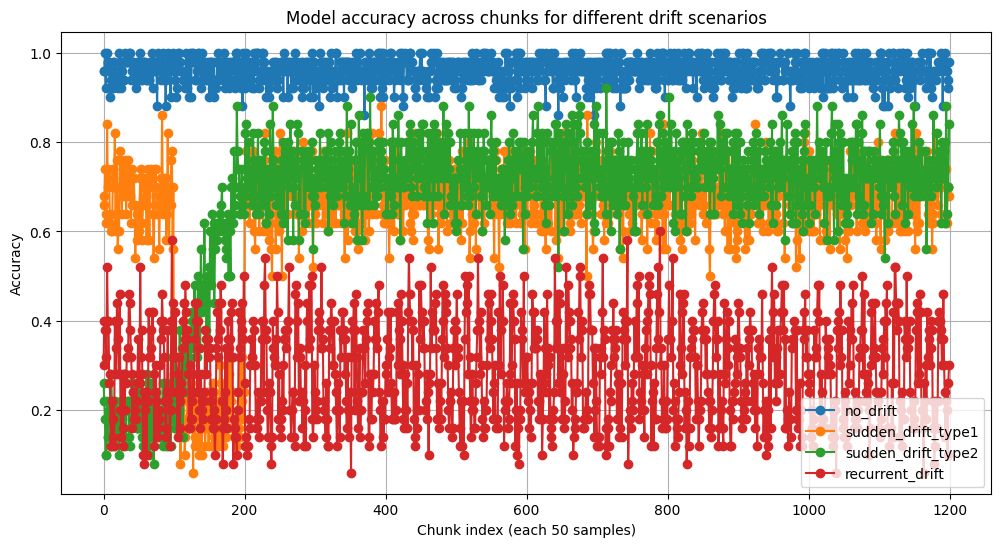

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Correct dataset dictionary names
datasets = {
    "no_drift": df_nodrift,
    "sudden_drift_type1": df_sudden_type1,
    "sudden_drift_type2": df_sudden_type2,
    "recurrent_drift": df_recurrent,
}

features = [
    'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
    'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean', 'accelerometer_x_std',
    'accelerometer_x_mad', 'accelerometer_x_max', 'accelerometer_x_min',
    'accelerometer_x_sma', 'accelerometer_y_mean', 'accelerometer_y_std',
    'accelerometer_y_mad', 'accelerometer_y_max', 'accelerometer_y_min',
    'accelerometer_y_sma', 'accelerometer_z_mean', 'accelerometer_z_std',
    'accelerometer_z_mad', 'accelerometer_z_max', 'accelerometer_z_min',
    'accelerometer_z_sma', 'gyroscope_x_mean', 'gyroscope_x_std',
    'gyroscope_x_mad', 'gyroscope_x_max', 'gyroscope_x_min', 'gyroscope_x_sma',
    'gyroscope_y_mean', 'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
    'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean', 'gyroscope_z_std',
    'gyroscope_z_mad', 'gyroscope_z_max', 'gyroscope_z_min', 'gyroscope_z_sma'
]
target = 'activity'

scaler = StandardScaler()
chunk_size = 50  # samples per evaluation chunk

plt.figure(figsize=(12,6))

for name, df_mod in datasets.items():
    X = df_mod[features].values
    y = df_mod[target].values

    # Scale features
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(-1, len(features), 1)

    # One-hot encode labels
    num_classes = len(np.unique(y))
    y_categorical = to_categorical(y, num_classes=num_classes)

    # Evaluate in chunks
    n_samples = X_scaled.shape[0]
    n_chunks = n_samples // chunk_size
    accs = []

    for i in range(n_chunks):
        start, end = i * chunk_size, (i + 1) * chunk_size
        X_chunk, y_chunk = X_scaled[start:end], y_categorical[start:end]
        if len(X_chunk) == 0:
            continue
        loss, accuracy = model.evaluate(X_chunk, y_chunk, verbose=0)
        accs.append(accuracy)

    plt.plot(range(len(accs)), accs, marker='o', label=name)

plt.title("Model accuracy across chunks for different drift scenarios")
plt.xlabel(f"Chunk index (each {chunk_size} samples)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


**Client Side Perfromace Drift Detction**
---

**Data Monitor**
---

In [ ]:
df_sudden_type1

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,0.493654,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242,3,sudden_type1
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,0.645855,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762,0,sudden_type1
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,-0.694472,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305,3,sudden_type1
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,0.441865,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000,0,sudden_type1
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,0.745672,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845,1,sudden_type1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729,2,sudden_type1
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953,0,sudden_type1
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931,1,sudden_type1
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594,3,sudden_type1


In [ ]:
df_sudden_type2

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type
0,-6.704082,2.983887,-2.233459,2.456514,1.941872,-1.308947,-0.619009,-7.366440,-3.704103,-8.833753,...,1.840160,8.635630,-3.267222,-1.458093,-2.799474,-2.766109,1.909407,-1.952948,0,sudden_type2
1,-4.462664,0.552605,-8.395338,3.243898,-1.666111,2.673364,4.996705,-4.680066,6.967212,-0.253909,...,-3.828486,3.882310,1.243349,7.646586,-4.174453,-5.559916,-1.257786,2.736155,4,sudden_type2
2,2.208331,1.928012,-2.445225,-4.495130,-0.270395,0.862733,2.508627,1.064762,7.271811,-10.510764,...,4.610120,-3.356942,-4.247614,-9.843075,-3.611678,-5.190573,5.009389,0.392784,0,sudden_type2
3,-8.697711,-1.878680,-8.364658,-5.597477,0.741130,-8.302694,-0.816686,-5.852520,-0.384091,5.600899,...,6.613828,-4.845299,10.309667,6.493449,-4.339215,-3.393780,4.865013,1.629256,2,sudden_type2
4,-0.028958,4.678717,-6.106643,6.124646,-1.112705,-6.115728,3.969675,-1.866510,-4.146045,6.609305,...,8.461463,-10.361786,-4.361331,-3.427821,-0.710794,-7.568993,-3.502338,-8.074670,3,sudden_type2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.557755,-1.129075,0.761236,-0.043621,-0.074405,0.018387,0.921577,-0.701506,-0.682775,-0.127684,...,0.761342,-0.794282,-0.016763,-0.733855,-0.672965,-0.713343,0.668644,-0.811729,2,sudden_type2
59996,-1.525760,-0.135729,-0.007843,-0.170920,-0.429152,0.346962,-0.878257,-0.178919,-0.219808,-0.815239,...,0.413116,-0.123984,-1.239974,-0.157502,-0.366559,-0.459160,-0.264294,0.160953,0,sudden_type2
59997,-0.319333,-0.041904,0.227377,-0.068098,-0.100612,-0.007199,-0.451486,-0.697648,-0.686646,-0.981895,...,0.728645,-0.785989,-0.035101,-0.728395,-0.671237,-0.721523,0.648699,-0.802931,1,sudden_type2
59998,0.229527,-0.390148,0.998480,-0.020637,-0.117322,-0.035777,0.180712,-0.332152,-0.253628,-0.137358,...,0.549200,-0.612284,-0.089804,-0.635867,-0.570966,-0.607979,0.565073,-0.710594,3,sudden_type2


In [ ]:
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'

# Step 3: Train-test split
X = df_sudden_type1[features].values
y= df_sudden_type1[target].values

# Normalize features
X = scaler.fit_transform(X)
#joblib.dump(scaler, '/content/drive/My Drive/Early Drift Detection/scaler.pkl')
# Reshape for CNN: (samples, time_steps=6, channels=1)
X = X.reshape(-1, len(features), 1)
# One-hot encode target
#num_classes = len(unique_labels)
#y_cat = to_categorical(y, num_classes)
y = y.reshape(-1, 1)
y_categorical = to_categorical(y, num_classes=5)
# Evaluate model
loss, accuracy = model.evaluate(X, y_categorical)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_probs = model.predict(X)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # numeric classes

# Flatten X back to original feature shape
X_flat = X.reshape(X.shape[0], X.shape[1])

# Build DataFrame with features + true label + prediction
df_results = pd.DataFrame(X_flat, columns=features)
df_results['true_activity'] = y.flatten()
df_results['predicted_activity'] = y_pred_classes

# Save if needed
df_results.to_csv('predictions_with_features.csv', index=False)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5980 - loss: 4.5997
Test Accuracy: 0.6439
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [ ]:
df_results

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,true_activity,predicted_activity
0,-0.191673,-0.302848,0.178225,-0.183398,0.226662,-0.214533,0.331286,-0.249996,-0.297491,0.198952,...,0.398144,-0.457345,0.195605,-0.127140,-0.110428,-0.408741,0.434852,-0.170774,3,3
1,-0.105961,-0.081996,-0.998474,-1.241250,0.985232,0.208680,-0.092212,-0.312117,-0.443090,-0.096399,...,0.472117,-0.238593,0.460691,0.231123,0.310718,0.019775,0.342172,0.193686,0,0
2,0.274543,-0.419934,0.832650,-0.050108,-0.154935,0.101921,0.147410,0.254831,0.276093,0.728373,...,-0.179306,-0.169632,0.344870,-0.030746,-0.044773,-0.224920,0.380838,-0.040538,3,3
3,-0.761884,-0.367788,-0.335841,-0.432243,-0.041286,-0.449191,-0.459903,-0.200305,-0.178891,-0.342913,...,0.372974,0.415553,1.099366,0.226754,0.139501,0.273693,0.256967,0.538621,0,0
4,-0.321334,-0.173021,-0.202220,-0.172987,0.142281,-0.145463,-0.092975,-0.491177,-0.497544,-0.329914,...,0.520629,-0.536452,0.151281,-0.184423,-0.166190,-0.506293,0.480456,-0.227096,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.107538,-0.706043,0.197712,-0.185752,0.118837,-0.150209,0.603310,-0.492493,-0.495054,0.102261,...,0.528246,-0.538221,0.154425,-0.184195,-0.165491,-0.502255,0.483980,-0.227520,2,1
59996,-0.898118,-0.222078,-0.167800,-0.246826,-0.055477,0.006199,-0.263157,-0.241247,-0.268498,-0.226368,...,0.359001,-0.220971,-0.421461,0.087691,-0.016289,-0.380501,0.034987,0.238317,0,0
59997,-0.315808,-0.176365,-0.056009,-0.197495,0.105960,-0.162388,-0.057703,-0.490638,-0.496948,-0.306025,...,0.512354,-0.534296,0.145792,-0.181619,-0.164650,-0.506173,0.474381,-0.223306,1,3
59998,-0.050888,-0.346033,0.310464,-0.174725,0.097749,-0.175991,0.246646,-0.314917,-0.285048,0.097637,...,0.425141,-0.452082,0.120038,-0.137970,-0.115824,-0.451786,0.434134,-0.179084,3,3


**MLaaS Extraction Model**
---

In [ ]:
df_results[['predicted_activity']]

,predicted_activity
0,3
1,0
2,3
3,0
4,0
...,...
59995,1
59996,0
59997,3
59998,3


Surrogate accuracy vs. black-box predictions: 0.8356


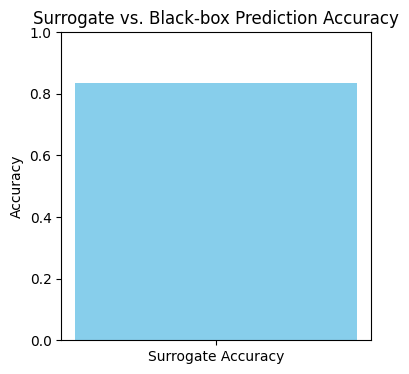

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# X = features, y_surrogate = black-box predictions
X_surrogate = df_results[features].values
y_surrogate = df_results['predicted_activity'].values
# Train surrogate (Decision Tree)
df_surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
df_surrogate.fit(X_surrogate, y_surrogate)
# Predict with surrogate
y_surrogate_pred = df_surrogate.predict(X_surrogate)
# Calculate accuracy vs. black-box predictions
acc = accuracy_score(y_surrogate, y_surrogate_pred)
print(f"Surrogate accuracy vs. black-box predictions: {acc:.4f}")
# Plot the accuracy as a simple bar
plt.figure(figsize=(4,4))
plt.bar(['Surrogate Accuracy'], [acc], color='skyblue')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Surrogate vs. Black-box Prediction Accuracy')
plt.show()

**Extract Important Feature**


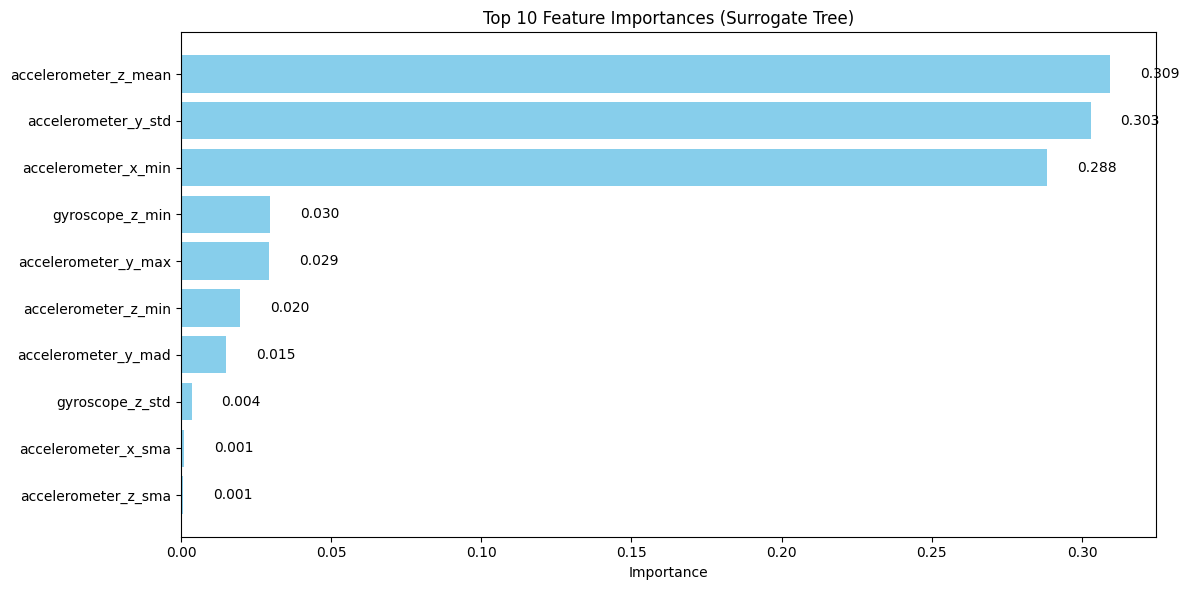

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We assume you already have:
# - a trained DecisionTreeClassifier called df_surrogate
# - your features list called features

# Get feature importances from the already-trained surrogate
importances = df_surrogate.feature_importances_
indices = np.argsort(importances)[::-1]  # sort descending

# Take top 10
top_n = 10
top_indices = indices[:top_n]
top_features = [features[i] for i in top_indices]
top_importances = importances[top_indices]

# Plot with importance values
plt.figure(figsize=(12,6))
bars = plt.barh(range(top_n), top_importances[::-1], color='skyblue')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Surrogate Tree)')

# Add importance values at the end of each bar
for i, b in enumerate(bars):
    width = b.get_width()
    plt.text(width + 0.01, b.get_y() + b.get_height()/2,
             f"{top_importances[::-1][i]:.3f}",
             va='center')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Get feature importances from the already-trained surrogate
importances = df_surrogate.feature_importances_

# Build a DataFrame of all features with their importances
df_baseline_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# Sort descending
df_baseline_importance = df_baseline_importance.sort_values(
    by='importance', ascending=False
).reset_index(drop=True)

# If you only want top 10:
df_baseline_top10 = df_baseline_importance.head(10)

# Display
print(df_baseline_top10)

                feature  importance
0  accelerometer_z_mean    0.309231
1   accelerometer_y_std    0.302852
2   accelerometer_x_min    0.288383
3       gyroscope_z_min    0.029618
4   accelerometer_y_max    0.029337
5   accelerometer_z_min    0.019776
6   accelerometer_y_mad    0.014881
7       gyroscope_z_std    0.003532
8   accelerometer_x_sma    0.001098
9   accelerometer_z_sma    0.000808


**Base line statictsics from ground truth**
---

In [ ]:
import pandas as pd

# --- config ---
block_size = 50
selected_cols = [
    'accelerometer_x_mean','accelerometer_x_var','accelerometer_x_std',
    'accelerometer_y_mean','accelerometer_y_var','accelerometer_y_std',
    'accelerometer_z_mean','accelerometer_z_var','accelerometer_z_std',
    'gyroscope_x_mean','gyroscope_x_var','gyroscope_x_std',
    'gyroscope_y_mean','gyroscope_y_var','gyroscope_y_std',
    'gyroscope_z_mean','gyroscope_z_var','gyroscope_z_std'
]

# Make a copy; assign block index
df_tmp = df_nodrift.copy()
df_tmp['block'] = df_tmp.index // block_size

# Filter to only available columns
cols_to_use = [c for c in selected_cols if c in df_tmp.columns]
if len(cols_to_use) < len(selected_cols):
    print("Warning: some selected columns missing and skipped")

# Compute mean, var, std per block for the selected columns
df_baseline_stats = (
    df_tmp
    .groupby('block')[cols_to_use]
    .agg(['mean','var','std'])
)

# Flatten the MultiIndex columns
df_baseline_stats.columns = [
    f"{col}_{stat}" for col, stat in df_baseline_stats.columns
]

# Reset index so 'block' becomes a column
df_baseline_stats = df_baseline_stats.reset_index()

# Now df_baseline_stats has one row per 6 000-row block


df_baseline_stats.to_csv("df_baseline_stats.csv")
df_baseline_stats

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,-0.066169,0.862088,0.928487,0.131633,1.198173,1.094611,-0.292174,1.382758,1.175907,...,1.136229,0.069691,0.880568,0.938386,-0.044772,1.004261,1.002128,0.134411,1.085345,1.041799
1196,1196,0.085570,1.790338,1.338035,-0.133436,0.964963,0.982325,-0.084010,0.888449,0.942576,...,1.050514,-0.175468,0.723632,0.850666,0.046394,0.831377,0.911799,-0.184814,0.876798,0.936375
1197,1197,-0.040105,0.912422,0.955208,0.174467,1.478390,1.215891,0.188862,0.875765,0.935823,...,0.803793,0.142433,1.349997,1.161894,0.128372,1.007839,1.003912,0.154634,1.040462,1.020030
1198,1198,0.087796,1.386688,1.177577,0.136510,1.599861,1.264856,0.221795,0.929070,0.963883,...,0.904533,-0.013303,1.143300,1.069252,-0.073012,0.920248,0.959296,0.062836,1.499345,1.224478


In [ ]:
# Compute DES per block
des_values = []
for idx, row in df_baseline_stats.iterrows():
    total = 0.0
    for _, feat_row in df_baseline_top10.iterrows():
        feature_name = feat_row["feature"]
        importance = feat_row["importance"]

        # Find all columns in df_baseline that start with this feature
        matching_cols = [c for c in df_baseline_stats.columns if c.startswith(feature_name)]
        for mc in matching_cols:
            total += importance * row[mc]

    des_values.append(total)

# Add DES column
df_baseline_stats["DES"] = des_values

# Show results
print("recurrent_drift", df_baseline_stats[["block", "DES"]])

recurrent_drift       block       DES
0         0  1.090134
1         1  1.387693
2         2  1.395804
3         3  1.136157
4         4  1.669928
...     ...       ...
1195   1195  1.053500
1196   1196  1.091303
1197   1197  1.272544
1198   1198  1.456486
1199   1199  1.502863

[1200 rows x 2 columns]


**New Data Statictsics**
---

In [ ]:
import pandas as pd

# --- config ---
block_size = 50  # size of each chunk
selected_cols = [
    'accelerometer_x_mean','accelerometer_x_var','accelerometer_x_std',
    'accelerometer_y_mean','accelerometer_y_var','accelerometer_y_std',
    'accelerometer_z_mean','accelerometer_z_var','accelerometer_z_std',
    'gyroscope_x_mean','gyroscope_x_var','gyroscope_x_std',
    'gyroscope_y_mean','gyroscope_y_var','gyroscope_y_std',
    'gyroscope_z_mean','gyroscope_z_var','gyroscope_z_std'
]

# --- load/prepare data ---
# Combine all drift datasets into one
df_all = pd.concat(
    [df_sudden_type1, df_sudden_type2, df_recurrent],
    axis=0,
    ignore_index=True
)
# Assign block IDs
df_all['block'] = df_all.index // block_size
# Filter to only available columns (skip any missing ones gracefully)
cols_to_use = [c for c in selected_cols if c in df_all.columns]
if len(cols_to_use) < len(selected_cols):
    print("Warning: some selected columns missing and skipped")
# Compute mean/var/std per block for the selected columns
df_all_stats = (
    df_all
    .groupby('block')[cols_to_use]
    .agg(['mean','var','std'])
)
# Flatten the MultiIndex columns for cleaner names
df_all_stats.columns = [
    f"{col}_{stat}" for col, stat in df_all_stats.columns
]

# Reset index so 'block' becomes a column
df_all_stats = df_all_stats.reset_index()

# Save to CSV
df_all_stats.to_csv("df_all_drifts.csv", index=False)

print("✅ Combined drift statistics saved to df_all_drifts.csv")

✅ Combined drift statistics saved to df_all_drifts.csv


In [ ]:
df_all_stats

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,5.084007,30.299647,5.504511,5.719861,31.812834,5.640287,-4.782856,30.220970,5.497360,...,6.596062,-5.802143,41.213289,6.419758,-3.545096,32.616969,5.711127,5.580636,54.869404,7.407388
3596,3596,5.764280,55.735562,7.465625,5.204006,45.574279,6.750872,-4.743979,39.901177,6.316738,...,5.977509,-5.325693,39.866635,6.314003,-6.283171,31.417921,5.605169,3.781797,28.407199,5.329840
3597,3597,4.699295,52.300243,7.231891,5.376885,36.367113,6.030515,-4.871091,24.050661,4.904147,...,4.545335,-3.967714,38.801393,6.229076,-4.483531,43.683440,6.609345,6.832979,38.318734,6.190213
3598,3598,6.596273,53.710448,7.328741,6.259389,44.434742,6.665939,-6.477835,35.317432,5.942847,...,5.338250,-4.396350,31.810475,5.640078,-5.069411,44.569548,6.676043,6.982302,28.771561,5.363913


In [ ]:
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
# Load your files
df_baseline = pd.read_csv('/content/df_baseline_stats.csv')
df_incremental = pd.read_csv('/content/df_all_drifts.csv')
df_baseline

,Unnamed: 0,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,1195,-0.066169,0.862088,0.928487,0.131633,1.198173,1.094611,-0.292174,1.382758,...,1.136229,0.069691,0.880568,0.938386,-0.044772,1.004261,1.002128,0.134411,1.085345,1.041799
1196,1196,1196,0.085570,1.790338,1.338035,-0.133436,0.964963,0.982325,-0.084010,0.888449,...,1.050514,-0.175468,0.723632,0.850666,0.046394,0.831377,0.911799,-0.184814,0.876798,0.936375
1197,1197,1197,-0.040105,0.912422,0.955208,0.174467,1.478390,1.215891,0.188862,0.875765,...,0.803793,0.142433,1.349997,1.161894,0.128372,1.007839,1.003912,0.154634,1.040462,1.020030
1198,1198,1198,0.087796,1.386688,1.177577,0.136510,1.599861,1.264856,0.221795,0.929070,...,0.904533,-0.013303,1.143300,1.069252,-0.073012,0.920248,0.959296,0.062836,1.499345,1.224478


In [ ]:
df_incremental = pd.read_csv('/content/df_all_drifts.csv')
df_incremental

,block,accelerometer_x_mean_mean,accelerometer_x_mean_var,accelerometer_x_mean_std,accelerometer_x_std_mean,accelerometer_x_std_var,accelerometer_x_std_std,accelerometer_y_mean_mean,accelerometer_y_mean_var,accelerometer_y_mean_std,...,gyroscope_y_mean_std,gyroscope_y_std_mean,gyroscope_y_std_var,gyroscope_y_std_std,gyroscope_z_mean_mean,gyroscope_z_mean_var,gyroscope_z_mean_std,gyroscope_z_std_mean,gyroscope_z_std_var,gyroscope_z_std_std
0,0,0.240303,0.880679,0.938445,-0.041462,1.021871,1.010876,-0.113114,1.153845,1.074172,...,0.829040,-0.003405,1.161637,1.077793,-0.138304,0.874010,0.934885,-0.159756,0.708265,0.841585
1,1,-0.118792,1.145621,1.070337,0.122060,1.607822,1.267999,0.164479,1.005699,1.002846,...,1.184949,0.163806,1.280543,1.131611,0.092642,0.884840,0.940659,0.083736,1.337586,1.156541
2,2,-0.172385,0.767719,0.876196,0.184838,1.116024,1.056420,-0.070193,1.239932,1.113523,...,1.079160,0.088931,0.892928,0.944949,-0.239944,1.234991,1.111302,0.177848,1.163928,1.078855
3,3,-0.076301,0.543047,0.736917,0.006184,0.926004,0.962291,-0.029066,1.091629,1.044811,...,1.033727,-0.097040,0.970363,0.985070,0.003542,0.922094,0.960257,-0.126275,0.857653,0.926096
4,4,-0.000319,1.191020,1.091339,0.103334,1.241855,1.114385,0.107726,1.522634,1.233951,...,1.035138,0.137092,1.645884,1.282920,-0.161715,0.793980,0.891056,0.070545,1.270195,1.127029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,5.084007,30.299647,5.504511,5.719861,31.812834,5.640287,-4.782856,30.220970,5.497360,...,6.596062,-5.802143,41.213289,6.419758,-3.545096,32.616969,5.711127,5.580636,54.869404,7.407388
3596,3596,5.764280,55.735562,7.465625,5.204006,45.574279,6.750872,-4.743979,39.901177,6.316738,...,5.977509,-5.325693,39.866635,6.314003,-6.283171,31.417921,5.605169,3.781797,28.407199,5.329840
3597,3597,4.699295,52.300243,7.231891,5.376885,36.367113,6.030515,-4.871091,24.050661,4.904147,...,4.545335,-3.967714,38.801393,6.229076,-4.483531,43.683440,6.609345,6.832979,38.318734,6.190213
3598,3598,6.596273,53.710448,7.328741,6.259389,44.434742,6.665939,-6.477835,35.317432,5.942847,...,5.338250,-4.396350,31.810475,5.640078,-5.069411,44.569548,6.676043,6.982302,28.771561,5.363913


**Model-Aware Drift Exposure Score (DES)**
---

In [ ]:
import pandas as pd
import numpy as np

# Paths (your uploaded files)
baseline_path = "df_baseline_stats.csv"
drift_path    = "df_all_drifts.csv"

df_baseline = pd.read_csv(baseline_path)
df_drift    = pd.read_csv(drift_path)

# Drop any accidental index column (common in CSV exports)
df_baseline = df_baseline.loc[:, ~df_baseline.columns.str.contains(r"^Unnamed")]

# Use only columns common to both files (excluding block)
common_cols = sorted(set(df_baseline.columns).intersection(df_drift.columns) - {"block"})

# Identify base feature names from columns like: base_mean, base_var, base_std
base_features = sorted({
    c.rsplit("_", 1)[0]
    for c in common_cols
    if c.rsplit("_", 1)[1] in ("mean", "var", "std")
})

def mu_var_from_row(row, base):
    """Extract (mu, var) for a base feature from a row with fallbacks."""
    mu  = row.get(f"{base}_mean", np.nan)
    var = row.get(f"{base}_var", np.nan)

    # fallback: var from std^2
    if pd.isna(var):
        std = row.get(f"{base}_std", np.nan)
        if not pd.isna(std):
            var = float(std) ** 2

    # enforce non-negative variance if present
    if not pd.isna(var):
        var = max(float(var), 0.0)

    return (float(mu) if not pd.isna(mu) else np.nan,
            float(var) if not pd.isna(var) else np.nan)

# ---- Build baseline distribution parameters ----
baseline_row = df_baseline[["block"] + common_cols].mean(numeric_only=True)

mu_b = np.array([mu_var_from_row(baseline_row, base)[0] for base in base_features], dtype=float)
v_b  = np.array([mu_var_from_row(baseline_row, base)[1] for base in base_features], dtype=float)

# ---- FDDS (diagonal covariance) per drift window ----
out = []
for i, r in df_drift.iterrows():
    block_id = r["block"] if "block" in df_drift.columns else i

    mu_w = np.array([mu_var_from_row(r, base)[0] for base in base_features], dtype=float)
    v_w  = np.array([mu_var_from_row(r, base)[1] for base in base_features], dtype=float)

    # Handle missing values by masking
    mask_mu = ~np.isnan(mu_b) & ~np.isnan(mu_w)
    mask_v  = ~np.isnan(v_b)  & ~np.isnan(v_w)

    mean_term = np.sum((mu_b[mask_mu] - mu_w[mask_mu])**2) if mask_mu.any() else np.nan
    cov_term  = np.sum(v_b[mask_v] + v_w[mask_v] - 2*np.sqrt(v_b[mask_v]*v_w[mask_v])) if mask_v.any() else np.nan

    fdds = float(mean_term + cov_term) if (not np.isnan(mean_term) and not np.isnan(cov_term)) else np.nan
    out.append({"block": block_id, "FDDS": fdds})

df_fdds = pd.DataFrame(out).sort_values("block").reset_index(drop=True)
df_fdds


,block,FDDS
0,0.0,0.305327
1,1.0,0.698357
2,2.0,0.486844
3,3.0,0.306265
4,4.0,0.628198
...,...,...
3595,3595.0,621.087815
3596,3596.0,654.189442
3597,3597.0,691.063477
3598,3598.0,732.860146


In [83]:
import pandas as pd
import numpy as np

# -----------------------------
# Parameters
# -----------------------------
group_size = 5              # number of blocks per group
threshold_scaled = 0.1     # threshold in [0,1]

# -----------------------------
# Step 0: Ensure correct column names
# -----------------------------
df_fdds = df_fdds.copy()    # safety
df_fdds.rename(columns={"FDDS": "FTDS"}, inplace=True, errors="ignore")

# -----------------------------
# Step 1: Scale FTDS to [0,1]
# -----------------------------
min_f = df_fdds["FTDS"].min()
max_f = df_fdds["FTDS"].max()

# protect against divide-by-zero
if max_f - min_f == 0:
    df_fdds["FTDS_scaled"] = 0.0
else:
    df_fdds["FTDS_scaled"] = (df_fdds["FTDS"] - min_f) / (max_f - min_f)

# -----------------------------
# Step 2: Assign block groups
# -----------------------------
df_fdds["block_group"] = (df_fdds["block"] // group_size).astype(int)

# -----------------------------
# Step 3: Aggregate FTDS per group
# -----------------------------
results = []
for gid, subset in df_fdds.groupby("block_group"):
    results.append({
        "block_range": f"{subset['block'].min():.0f}-{subset['block'].max():.0f}",
        "total_blocks": len(subset),
        "avg_FTDS": subset["FTDS"].mean(),
        "avg_FTDS_scaled": subset["FTDS_scaled"].mean()
    })

df_fdds_summary = pd.DataFrame(results)

# -----------------------------
# Step 4: Drift decision
# -----------------------------
df_fdds_summary["final_drift"] = np.where(
    df_fdds_summary["avg_FTDS_scaled"] > threshold_scaled,
    "REAL_DRIFT",
    "PSEUDO_DRIFT"
)

# -----------------------------
# Output
# -----------------------------
print(df_fdds_summary)

    block_range  total_blocks    avg_FTDS  avg_FTDS_scaled   final_drift
0           0-4             5    0.484998         0.000465  PSEUDO_DRIFT
1           5-9             5    0.669010         0.000690  PSEUDO_DRIFT
2         10-14             5    0.518892         0.000506  PSEUDO_DRIFT
3         15-19             5    0.403009         0.000364  PSEUDO_DRIFT
4         20-24             5    0.821329         0.000876  PSEUDO_DRIFT
..          ...           ...         ...              ...           ...
715   3575-3579             5  508.823490         0.622899    REAL_DRIFT
716   3580-3584             5  514.956292         0.630409    REAL_DRIFT
717   3585-3589             5    0.520310         0.000508  PSEUDO_DRIFT
718   3590-3594             5  440.094439         0.538744    REAL_DRIFT
719   3595-3599             5  678.650588         0.830844    REAL_DRIFT

[720 rows x 5 columns]


<Axes: >

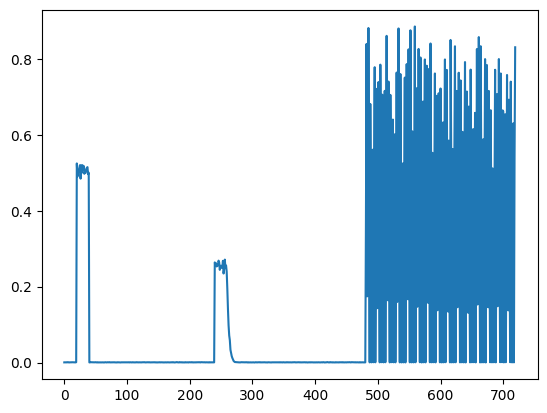

In [84]:
df_fdds_summary['avg_FTDS_scaled'].plot()

In [85]:
df_all

,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,accelerometer_x_max,...,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type,block
0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,0.074613,...,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242,3,sudden_type1,0
1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,-0.543317,...,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762,0,sudden_type1,0
2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,1.182263,...,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305,3,sudden_type1,0
3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,-1.059074,...,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000,0,sudden_type1,0
4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,-1.031876,...,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845,1,sudden_type1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,-14.202733,-4.997898,-4.015031,5.970888,3.154990,-7.858504,-3.145390,-1.833837,-18.162297,1.587005,...,1.875735,-5.237823,8.266627,-6.553798,3.655535,2.454834,0.854766,1,recurrent,3599
179996,-10.133820,7.905229,-2.876184,1.282330,9.225757,-6.989413,-7.569375,2.268653,-12.150884,-0.883657,...,-8.710775,-7.250605,1.390476,-8.160141,-18.664237,5.523400,-9.501949,1,recurrent,3599
179997,1.776811,8.915643,1.482578,-1.665699,3.615920,-7.029021,-2.136366,-1.645876,-6.705811,12.849680,...,0.132096,-7.229185,1.904581,-7.821637,2.264068,4.721420,1.795641,3,recurrent,3599
179998,-0.293542,1.477696,-2.923954,11.354086,8.594036,-10.353322,-11.665212,4.465592,1.585667,-5.838130,...,-11.199728,5.292577,11.039075,7.144664,-0.068193,-0.763664,-3.490852,1,recurrent,3599


In [86]:
df_all.to_csv("/content/drive/My Drive/Early Drift Detection/Drifted_HAR_data.csv")

In [87]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
# --- config ---
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
num_classes = 5  # adjust to your actual number of activity classes
time_steps = len(features)
df_tmp=df_all
# --- evaluation over 5-block windows ---
accuracies = []
block_ids = sorted(df_tmp['block'].unique())

# process in chunks of 5 blocks at a time
for i in range(0, len(block_ids), 5):
    block_chunk = block_ids[i:i+5]
    df_chunk = df_tmp[df_tmp['block'].isin(block_chunk)]
    if df_chunk.empty:
        continue

    # prepare X and y
    X_chunk = df_chunk[features].values
    y_chunk = df_chunk[target].values

    # normalize
    X_chunk = scaler.transform(X_chunk)

    # reshape for CNN (samples, time_steps, channels)
    X_chunk = X_chunk.reshape(-1, time_steps, 1)

    # one-hot encode y
    y_chunk_cat = to_categorical(y_chunk, num_classes=num_classes)

    # evaluate model on this chunk
    loss, accuracy = model.evaluate(X_chunk, y_chunk_cat, verbose=0)
    accuracies.append({
        'block_range': f"{block_chunk[0]}-{block_chunk[-1]}",
        'accuracy': accuracy
    })
# convert to DataFrame
df_accuracies = pd.DataFrame(accuracies)
# save or inspect
df_accuracies.to_csv('blockwise_accuracies.csv', index=False)
print(df_accuracies)

    block_range  accuracy
0           0-4     0.668
1           5-9     0.724
2         10-14     0.656
3         15-19     0.716
4         20-24     0.660
..          ...       ...
715   3575-3579     0.256
716   3580-3584     0.292
717   3585-3589     0.732
718   3590-3594     0.392
719   3595-3599     0.228

[720 rows x 2 columns]


In [88]:
import numpy as np
# Assume df is your dataframe with 'accuracy'
df_accuracies["Ground truth"] = np.where(df_accuracies["accuracy"] > 0.50, "PSEUDO_DRIFT", "REAL_DRIFT")
df_accuracies

,block_range,accuracy,Ground truth
0,0-4,0.668,PSEUDO_DRIFT
1,5-9,0.724,PSEUDO_DRIFT
2,10-14,0.656,PSEUDO_DRIFT
3,15-19,0.716,PSEUDO_DRIFT
4,20-24,0.660,PSEUDO_DRIFT
...,...,...,...
715,3575-3579,0.256,REAL_DRIFT
716,3580-3584,0.292,REAL_DRIFT
717,3585-3589,0.732,PSEUDO_DRIFT
718,3590-3594,0.392,REAL_DRIFT


<Axes: >

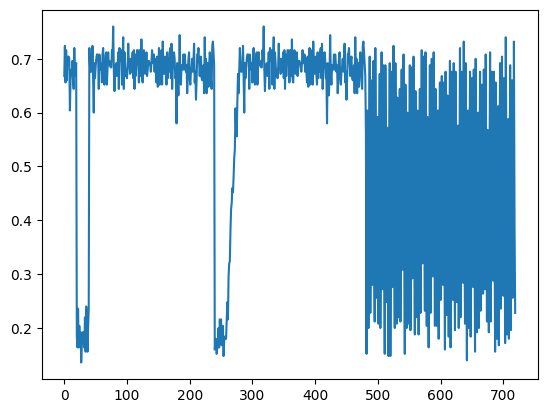

In [89]:
df_accuracies["accuracy"].plot()

In [90]:
df_accuracies['Ground truth'].value_counts()

,count
Ground truth,
PSEUDO_DRIFT,528
REAL_DRIFT,192


In [91]:
df_fdds_summary

,block_range,total_blocks,avg_FTDS,avg_FTDS_scaled,final_drift
0,0-4,5,0.484998,0.000465,PSEUDO_DRIFT
1,5-9,5,0.669010,0.000690,PSEUDO_DRIFT
2,10-14,5,0.518892,0.000506,PSEUDO_DRIFT
3,15-19,5,0.403009,0.000364,PSEUDO_DRIFT
4,20-24,5,0.821329,0.000876,PSEUDO_DRIFT
...,...,...,...,...,...
715,3575-3579,5,508.823490,0.622899,REAL_DRIFT
716,3580-3584,5,514.956292,0.630409,REAL_DRIFT
717,3585-3589,5,0.520310,0.000508,PSEUDO_DRIFT
718,3590-3594,5,440.094439,0.538744,REAL_DRIFT


In [92]:
df_fdds_summary["final_drift"].value_counts()

,count
final_drift,
PSEUDO_DRIFT,498
REAL_DRIFT,222


In [93]:
df_fdds_summary.to_csv("MPDD.csv")

In [94]:
df_accuracies.to_csv("Ground.csv")

In [95]:
df_fdds_summary

,block_range,total_blocks,avg_FTDS,avg_FTDS_scaled,final_drift
0,0-4,5,0.484998,0.000465,PSEUDO_DRIFT
1,5-9,5,0.669010,0.000690,PSEUDO_DRIFT
2,10-14,5,0.518892,0.000506,PSEUDO_DRIFT
3,15-19,5,0.403009,0.000364,PSEUDO_DRIFT
4,20-24,5,0.821329,0.000876,PSEUDO_DRIFT
...,...,...,...,...,...
715,3575-3579,5,508.823490,0.622899,REAL_DRIFT
716,3580-3584,5,514.956292,0.630409,REAL_DRIFT
717,3585-3589,5,0.520310,0.000508,PSEUDO_DRIFT
718,3590-3594,5,440.094439,0.538744,REAL_DRIFT


In [96]:
df_accuracies

,block_range,accuracy,Ground truth
0,0-4,0.668,PSEUDO_DRIFT
1,5-9,0.724,PSEUDO_DRIFT
2,10-14,0.656,PSEUDO_DRIFT
3,15-19,0.716,PSEUDO_DRIFT
4,20-24,0.660,PSEUDO_DRIFT
...,...,...,...
715,3575-3579,0.256,REAL_DRIFT
716,3580-3584,0.292,REAL_DRIFT
717,3585-3589,0.732,PSEUDO_DRIFT
718,3590-3594,0.392,REAL_DRIFT


In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
pred_df = pd.read_csv("MPDD.csv")
truth_df = pd.read_csv("Ground.csv")

# Merge on block_range
df = pd.merge(
    pred_df[["block_range", "final_drift"]],
    truth_df[["block_range", "Ground truth"]],
    on="block_range"
)

# Normalize labels
df["pred"] = df["final_drift"].str.upper()
df["true"] = df["Ground truth"].str.upper()

# Define confusion components
df["TP"] = ((df["pred"] == "REAL_DRIFT") & (df["true"] == "REAL_DRIFT")).astype(int)
df["FP"] = ((df["pred"] == "REAL_DRIFT") & (df["true"] == "PSEUDO_DRIFT")).astype(int)
df["TN"] = ((df["pred"] == "PSEUDO_DRIFT") & (df["true"] == "PSEUDO_DRIFT")).astype(int)
df["FN"] = ((df["pred"] == "PSEUDO_DRIFT") & (df["true"] == "REAL_DRIFT")).astype(int)

# Group into block windows (example: every 50 block_ranges)
df["group"] = (df.index // 50) * 50
summary = df.groupby("group")[["TP", "FP", "TN", "FN"]].sum().reset_index()
summary

,group,TP,FP,TN,FN
0,0,20,0,30,0
1,50,0,0,50,0
2,100,0,0,50,0
3,150,0,0,50,0
4,200,10,0,40,0
5,250,12,0,29,9
6,300,0,0,50,0
7,350,0,0,50,0
8,400,0,0,50,0
9,450,11,4,35,0


**Θ=0.1**
---

In [98]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_fdds_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9333333333333333
F1 Score: 0.9347741334011357
Precision: 0.9399001411049602
Recall: 0.9333333333333333
Confusion Matrix:
 [[489  39]
 [  9 183]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.98      0.93      0.95       528
  REAL_DRIFT       0.82      0.95      0.88       192

    accuracy                           0.93       720
   macro avg       0.90      0.94      0.92       720
weighted avg       0.94      0.93      0.93       720



**Θ=0.7**
---

In [82]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_fdds_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8069444444444445
F1 Score: 0.7634076224632113
Precision: 0.8471764117941029
Recall: 0.8069444444444445
Confusion Matrix:
 [[528   0]
 [139  53]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.79      1.00      0.88       528
  REAL_DRIFT       1.00      0.28      0.43       192

    accuracy                           0.81       720
   macro avg       0.90      0.64      0.66       720
weighted avg       0.85      0.81      0.76       720



**Θ=0.5**
---

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_fdds_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8888888888888888
F1 Score: 0.8781813689152459
Precision: 0.9035087719298247
Recall: 0.8888888888888888
Confusion Matrix:
 [[528   0]
 [ 80 112]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.87      1.00      0.93       528
  REAL_DRIFT       1.00      0.58      0.74       192

    accuracy                           0.89       720
   macro avg       0.93      0.79      0.83       720
weighted avg       0.90      0.89      0.88       720



**Θ=0.3**
---

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = df_accuracies["Ground truth"][:]
y_pred = df_fdds_summary["final_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9375
F1 Score: 0.9355089355089355
Precision: 0.9389567147613762
Recall: 0.9375
Confusion Matrix:
 [[522   6]
 [ 39 153]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.93      0.99      0.96       528
  REAL_DRIFT       0.96      0.80      0.87       192

    accuracy                           0.94       720
   macro avg       0.95      0.89      0.92       720
weighted avg       0.94      0.94      0.94       720



In [100]:
Thresholds  = ["0.1","0.3","0.5","0.7"]
MDDP_Accuracy =["0.93","0.94","0.89 ","0.81"]

['0.93', '0.94', '0.89 ', '0.81']

***ADWIN for HAR Dataset***
---

In [101]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Define the paths to your datasets in Google Drive
import numpy as np
df_all=pd.read_csv("/content/drive/My Drive/Early Drift Detection/Drifted_HAR_data.csv")
df_all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,...,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma,activity,drift_type,block
0,0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,...,-0.623404,0.070705,-0.612909,-0.559886,-0.518116,0.566564,-0.693242,3,sudden_type1,0
1,1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,...,-0.161216,0.633761,0.146550,0.304989,0.376488,0.373989,0.067762,0,sudden_type1,0
2,2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,...,-0.015511,0.387750,-0.408569,-0.425055,-0.134356,0.454331,-0.421305,3,sudden_type1,0
3,3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,...,1.220891,1.990336,0.137288,-0.046625,0.906588,0.196947,0.788000,0,sudden_type1,0
4,4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,...,-0.790546,-0.023442,-0.734340,-0.674400,-0.721773,0.661322,-0.810845,1,sudden_type1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,179995,-14.202733,-4.997898,-4.015031,5.970888,3.154990,-7.858504,-3.145390,-1.833837,-18.162297,...,1.875735,-5.237823,8.266627,-6.553798,3.655535,2.454834,0.854766,1,recurrent,3599
179996,179996,-10.133820,7.905229,-2.876184,1.282330,9.225757,-6.989413,-7.569375,2.268653,-12.150884,...,-8.710775,-7.250605,1.390476,-8.160141,-18.664237,5.523400,-9.501949,1,recurrent,3599
179997,179997,1.776811,8.915643,1.482578,-1.665699,3.615920,-7.029021,-2.136366,-1.645876,-6.705811,...,0.132096,-7.229185,1.904581,-7.821637,2.264068,4.721420,1.795641,3,recurrent,3599
179998,179998,-0.293542,1.477696,-2.923954,11.354086,8.594036,-10.353322,-11.665212,4.465592,1.585667,...,-11.199728,5.292577,11.039075,7.144664,-0.068193,-0.763664,-3.490852,1,recurrent,3599


In [102]:
df_all['drift_type'].value_counts()

,count
drift_type,
sudden_type1,60000
sudden_type2,60000
recurrent,60000


In [103]:
df_accuracies = pd.read_csv("/content/Ground.csv")
df_accuracies

,Unnamed: 0,block_range,accuracy,Ground truth
0,0,0-4,0.668,PSEUDO_DRIFT
1,1,5-9,0.724,PSEUDO_DRIFT
2,2,10-14,0.656,PSEUDO_DRIFT
3,3,15-19,0.716,PSEUDO_DRIFT
4,4,20-24,0.660,PSEUDO_DRIFT
...,...,...,...,...
715,715,3575-3579,0.256,REAL_DRIFT
716,716,3580-3584,0.292,REAL_DRIFT
717,717,3585-3589,0.732,PSEUDO_DRIFT
718,718,3590-3594,0.392,REAL_DRIFT


In [104]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
# ==========================================================
# VARIANCE-AWARE ADWIN DRIFT DETECTOR
# ==========================================================
def adwin_detector_single_feature(data_stream, delta=0.002, min_window=10):
    """
    ADWIN for single feature — now variance-aware.
    Returns drift scores (0–1) combining mean + variance shift effects.
    """
    window = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        window.append(value)

        if len(window) < min_window:
            continue

        n = len(window)
        split_points = [int(0.3 * n), int(0.5 * n), int(0.7 * n)]
        max_drift_score = 0

        for split_point in split_points:
            if split_point < 5 or (n - split_point) < 5:
                continue

            w0 = np.array(window[:split_point])
            w1 = np.array(window[split_point:])

            n0, n1 = len(w0), len(w1)
            m = 1 / (1 / n0 + 1 / n1)

            mean0, mean1 = np.mean(w0), np.mean(w1)
            var0, var1 = np.var(w0), np.var(w1)

            pooled_var = ((n0 - 1) * var0 + (n1 - 1) * var1) / (n0 + n1 - 2)
            δ_prime = delta / n
            ε_cut = np.sqrt((2 / m) * pooled_var * np.log(2 / δ_prime)) + (2 / (3 * m)) * np.log(2 / δ_prime)

            # --- Mean difference component ---
            mean_diff = abs(mean0 - mean1)

            # --- Variance difference component (normalized) ---
            var_diff = abs(np.sqrt(var0) - np.sqrt(var1))

            # --- Combined drift magnitude (normalized) ---
            drift_mag = np.sqrt(mean_diff**2 + var_diff**2)

            # --- Relative drift score vs. threshold ---
            drift_score = min(1.0, drift_mag / (ε_cut + 1e-8))
            max_drift_score = max(max_drift_score, drift_score)

            # Adaptive window shrink if strong drift detected
            if drift_score > 0.7:
                window = w1.tolist()
                break

        drift_scores[i] = max_drift_score

        # Rolling window control
        if len(window) > 50:
            window = window[-25:]

    return drift_scores
# ==================== BLOCKWISE COMBINATION (ADWIN ONLY) ====================
def combine_adwin_drift_scores_blockwise(df, adwin_scores_dict, adwin_threshold=0.6, block_size=5):
    """
    Combine ADWIN drift scores from all features using block averages.
    Classifies each block as REAL_DRIFT or PSEUDO_DRIFT.
    Also prints and stores ADWIN block means for tuning.
    """
    df["block_group"] = (df["block"] // block_size).astype(int)
    adwin_block_labels = {}
    adwin_block_means = {}

    print("\n=== BLOCK-WISE ADWIN MEAN SCORES ===")
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        adwin_block_mean = np.mean([np.mean(adwin_scores_dict[col][idx]) for col in adwin_scores_dict])

        adwin_block_means[group_id] = adwin_block_mean  # store numeric value
        if adwin_block_mean > adwin_threshold:
            adwin_block_labels[group_id] = "REAL_DRIFT"
        else:
            adwin_block_labels[group_id] = "PSEUDO_DRIFT"

        # Print block statistics for inspection
        print(f"Block {group_id:3d}: Mean Score = {adwin_block_mean:.4f} → {adwin_block_labels[group_id]}")

    # Map results to dataframe
    df["ADWIN_drift"] = df["block_group"].map(adwin_block_labels)
    df["ADWIN_score_mean"] = df["block_group"].map(adwin_block_means)

    return df
# ==================== MAIN FUNCTION ====================
def detect_adwin_drift_all_columns(df, feature_columns=None, adwin_threshold=0.6, block_size=5):
    """
    Main function: Detect ADWIN drift on all specified columns with block averaging
    """
    if feature_columns is None:
        exclude_cols = ['activity', 'drift_type', 'block']
        feature_columns = [col for col in df.columns if col not in exclude_cols and
                           pd.api.types.is_numeric_dtype(df[col])]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    adwin_scores_dict = {}

    for col in feature_columns:
        print(f"Calculating ADWIN drift scores for {col}...")
        data = df[col].values
        adwin_scores_dict[col] = adwin_detector_single_feature(data)

    print("\nCombining ADWIN drift scores block-wise...")
    result_df = combine_adwin_drift_scores_blockwise(df.copy(), adwin_scores_dict,
                                                     adwin_threshold, block_size)

    adwin_real = (result_df['ADWIN_drift'] == 'REAL_DRIFT').sum()
    adwin_pseudo = (result_df['ADWIN_drift'] == 'PSEUDO_DRIFT').sum()

    print(f"\n=== ADWIN DRIFT DETECTION SUMMARY ===")
    print(f"REAL_DRIFT blocks: {adwin_real}")
    print(f"PSEUDO_DRIFT blocks: {adwin_pseudo}")
    print(f"Total blocks: {result_df['block_group'].nunique()}")

    return result_df
# ==================== SIMPLE USAGE ====================
def run_adwin_drift_detection(df_all, adwin_threshold=0.001, block_size=5):
    return detect_adwin_drift_all_columns(df_all, adwin_threshold=adwin_threshold, block_size=block_size)

In [105]:
result = detect_adwin_drift_all_columns(
    df_all,
    feature_columns=[
        'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
        'gyroscope_x', 'gyroscope_y', 'gyroscope_z'
    ],
    adwin_threshold=0.70,  # start with small threshold since data now normalized
    block_size=5
)
# Check block-level drift means
print("\n--- Drift Counts ---")
print(result['ADWIN_drift'].value_counts())
# Inspect block mean scores
print(result[['block_group', 'ADWIN_score_mean', 'ADWIN_drift']].drop_duplicates().head(20))
# Save results
result.to_csv('adwin_drift_detection_results.csv', index=False)

Processing 6 features: ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']
Calculating ADWIN drift scores for accelerometer_x...
Calculating ADWIN drift scores for accelerometer_y...
Calculating ADWIN drift scores for accelerometer_z...
Calculating ADWIN drift scores for gyroscope_x...
Calculating ADWIN drift scores for gyroscope_y...
Calculating ADWIN drift scores for gyroscope_z...

Combining ADWIN drift scores block-wise...

=== BLOCK-WISE ADWIN MEAN SCORES ===
Block   0: Mean Score = 0.2418 → PSEUDO_DRIFT
Block   1: Mean Score = 0.2979 → PSEUDO_DRIFT
Block   2: Mean Score = 0.2869 → PSEUDO_DRIFT
Block   3: Mean Score = 0.3180 → PSEUDO_DRIFT
Block   4: Mean Score = 0.2687 → PSEUDO_DRIFT
Block   5: Mean Score = 0.2943 → PSEUDO_DRIFT
Block   6: Mean Score = 0.3018 → PSEUDO_DRIFT
Block   7: Mean Score = 0.2578 → PSEUDO_DRIFT
Block   8: Mean Score = 0.2812 → PSEUDO_DRIFT
Block   9: Mean Score = 0.2859 → PSEUDO_DRIFT
Block  10: Mean Scor

In [120]:
threshold = 0.1

# Update the ADWIN_drift column based on the threshold
result['ADWIN_drift'] = result['ADWIN_score_mean'].apply(
    lambda x: 'REAL_DRIFT' if x > threshold else 'PSEUDO_DRIFT'
)

print(result)

        Unnamed: 0  accelerometer_x  accelerometer_y  accelerometer_z  \
0                0        -0.062151        -0.301512         0.720233   
1                1         0.115428         0.151791        -1.755679   
2                2         0.903755        -0.541831         2.097220   
3                3        -1.243512        -0.434802        -0.361421   
4                4        -0.330780        -0.035040        -0.080267   
...            ...              ...              ...              ...   
179995      179995       -14.202733        -4.997898        -4.015031   
179996      179996       -10.133820         7.905229        -2.876184   
179997      179997         1.776811         8.915643         1.482578   
179998      179998        -0.293542         1.477696        -2.923954   
179999      179999        -3.305911         7.164506        -0.554245   

        gyroscope_x  gyroscope_y  gyroscope_z  accelerometer_x_mean  \
0         -0.038716     0.145030    -0.116744       

In [121]:
result['ADWIN_drift'].value_counts()

,count
ADWIN_drift,
REAL_DRIFT,180000


<Axes: >

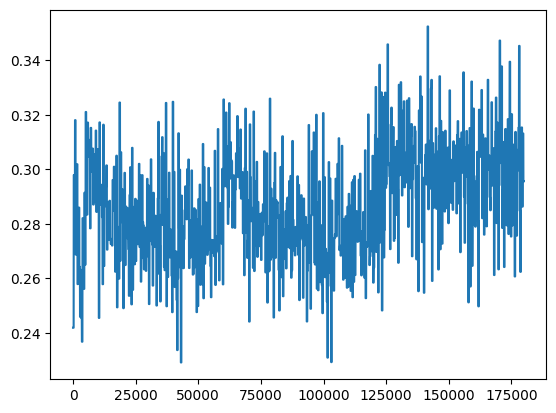

In [122]:
result['ADWIN_score_mean'].plot()

In [123]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"

# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "ADWIN_drift": majority_drift
}).reset_index()

# Step 4: Add block range string
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")

agg_results

,block_group,ADWIN_drift,block_range
0,0,REAL_DRIFT,0-4
1,1,REAL_DRIFT,5-9
2,2,REAL_DRIFT,10-14
3,3,REAL_DRIFT,15-19
4,4,REAL_DRIFT,20-24
...,...,...,...
715,715,REAL_DRIFT,3575-3579
716,716,REAL_DRIFT,3580-3584
717,717,REAL_DRIFT,3585-3589
718,718,REAL_DRIFT,3590-3594


**Θ=0.7**
---

In [109]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7333333333333333
F1 Score: 0.6205128205128205
Precision: 0.5377777777777778
Recall: 0.7333333333333333
Confusion Matrix:
 [[528   0]
 [192   0]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.73      1.00      0.85       528
  REAL_DRIFT       0.00      0.00      0.00       192

    accuracy                           0.73       720
   macro avg       0.37      0.50      0.42       720
weighted avg       0.54      0.73      0.62       720



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

**Θ=0.5**
---

In [114]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7333333333333333
F1 Score: 0.6205128205128205
Precision: 0.5377777777777778
Recall: 0.7333333333333333
Confusion Matrix:
 [[528   0]
 [192   0]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.73      1.00      0.85       528
  REAL_DRIFT       0.00      0.00      0.00       192

    accuracy                           0.73       720
   macro avg       0.37      0.50      0.42       720
weighted avg       0.54      0.73      0.62       720



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

**Θ=0.3**
---

In [119]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8083333333333333
F1 Score: 0.8104167671370287
Precision: 0.8131615730421972
Recall: 0.8083333333333333
Confusion Matrix:
 [[452  76]
 [ 62 130]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.88      0.86      0.87       528
  REAL_DRIFT       0.63      0.68      0.65       192

    accuracy                           0.81       720
   macro avg       0.76      0.77      0.76       720
weighted avg       0.81      0.81      0.81       720



**Θ=0.1**
---

In [124]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["ADWIN_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.26666666666666666
F1 Score: 0.11228070175438595
Precision: 0.07111111111111111
Recall: 0.26666666666666666
Confusion Matrix:
 [[  0 528]
 [  0 192]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.00      0.00      0.00       528
  REAL_DRIFT       0.27      1.00      0.42       192

    accuracy                           0.27       720
   macro avg       0.13      0.50      0.21       720
weighted avg       0.07      0.27      0.11       720



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

***MMD DETECTOR for HAR dataset***
---

In [125]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ============================================================
# MMD DETECTOR (SINGLE FEATURE)
# ============================================================
def mmd_detector_single_feature(data_stream, window_size=20):
    """
    Mean Maximum Discrepancy (MMD) for single feature - returns drift scores (0–1).
    """
    def rbf_kernel(x, y, sigma=1.0):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).reshape(-1, 1)
        dist_sq = np.sum(x**2, axis=1, keepdims=True) + np.sum(y**2, axis=1) - 2 * (x @ y.T)
        return np.exp(-dist_sq / (2 * sigma**2))

    reference = []
    current = []
    drift_scores = np.zeros(len(data_stream))

    for i, value in enumerate(data_stream):
        current.append(value)

        if len(current) > window_size:
            current = current[-window_size:]

        if len(reference) < window_size:
            reference.append(value)
            continue

        # Compute kernel matrices
        K_ref = rbf_kernel(reference, reference)
        K_curr = rbf_kernel(current, current)
        K_cross = rbf_kernel(reference, current)

        m, n = len(reference), len(current)
        mmd_sq = (np.sum(K_ref) - np.trace(K_ref)) / (m*(m-1)) \
                 + (np.sum(K_curr) - np.trace(K_curr)) / (n*(n-1)) \
                 - 2 * np.mean(K_cross)

        mmd_sq = max(0, mmd_sq)
        drift_score = min(1.0, mmd_sq * 10)  # scale factor for normalization
        drift_scores[i] = drift_score

        # Update reference window when strong drift detected
        if drift_score > 0.8:
            reference = current.copy()

    return drift_scores


# ============================================================
# COMBINE MMD DRIFT SCORES BLOCKWISE
# ============================================================
def combine_mmd_drift_scores_blockwise(df, mmd_scores_dict, mmd_threshold=0.7, block_size=5):
    """
    Combine MMD drift scores from all features using block averages (scaled 0–1).
    """
    df["block_group"] = (df["block"] // block_size).astype(int)
    mmd_block_means = []

    # Compute average drift score per block across all features
    for group_id, group_df in df.groupby("block_group"):
        idx = group_df.index
        mean_score = np.mean([
            np.mean(mmd_scores_dict[col][idx]) for col in mmd_scores_dict
        ])
        mmd_block_means.append((group_id, mean_score))

    # Convert to DataFrame for scaling
    mmd_block_df = pd.DataFrame(mmd_block_means, columns=["block_group", "MMD_score_mean"])

    # --- Scale block means between 0 and 1 ---
    scaler = MinMaxScaler()
    mmd_block_df["MMD_score_mean_scaled"] = scaler.fit_transform(
        mmd_block_df[["MMD_score_mean"]]
    )

    # --- Classify scaled means ---
    mmd_block_df["MMD_drift"] = np.where(
        mmd_block_df["MMD_score_mean_scaled"] > mmd_threshold,
        "real_drift",
        "pseudo_drift"
    )

    # Merge results back into original DataFrame
    df = df.merge(mmd_block_df, on="block_group", how="left")

    return df


# ============================================================
# MAIN FUNCTION (ELECTRICITY DATASET ADAPTATION)
# ============================================================
def detect_mmd_drift_all_columns(df, feature_columns=None, mmd_threshold=0.7, block_size=5):
    """
    Detect drift on all numeric columns using MMD-based scoring.
    Adapted for electricity dataset (nswprice, vicprice, transfer, vicdemand).
    """
    # --- Convert safely to numeric where possible ---
    df = df.apply(pd.to_numeric, errors='ignore')

    # --- Define features ---
    if feature_columns is None:
        exclude_cols = ['class', 'drift_type', 'block']
        feature_columns = [
            col for col in df.columns
            if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])
        ]

    print(f"Processing {len(feature_columns)} features: {feature_columns}")

    # --- Compute drift scores per feature ---
    mmd_scores_dict = {}
    for col in feature_columns:
        print(f"Calculating MMD drift scores for {col}...")
        data = df[col].values
        mmd_scores_dict[col] = mmd_detector_single_feature(data)

    print("\nCombining MMD drift scores block-wise...")
    result_df = combine_mmd_drift_scores_blockwise(
        df.copy(), mmd_scores_dict, mmd_threshold, block_size
    )

    # --- Summary ---
    mmd_real = (result_df['MMD_drift'] == 'real_drift').sum()
    mmd_pseudo = (result_df['MMD_drift'] == 'pseudo_drift').sum()

    print("\n=== MMD DRIFT DETECTION SUMMARY ===")
    print(f"Real drifts: {mmd_real}")
    print(f"Pseudo drifts: {mmd_pseudo}")
    print(f"Total block groups: {result_df['block_group'].nunique()}")

    return result_df


# ============================================================
# SIMPLE USAGE WRAPPER
# ============================================================
def run_mmd_drift_detection(df, mmd_threshold=0.7, block_size=5):
    """
    Simplified interface for running MMD drift detection end-to-end.
    """
    return detect_mmd_drift_all_columns(df, mmd_threshold=mmd_threshold, block_size=block_size)




In [144]:
# ==================== RUN MMD DRIFT DETECTION ====================
result = detect_mmd_drift_all_columns(
    df_all,
    feature_columns=['accelerometer_x', 'accelerometer_y', 'accelerometer_z',
        'gyroscope_x', 'gyroscope_y', 'gyroscope_z'],
    mmd_threshold=0.7,  # adjust based on sensitivity
    block_size=5
)

# --- Drift counts summary ---
print("\n--- Drift Counts ---")
print(result['MMD_drift'].value_counts())

# --- Compute block-level mean of numeric features (for inspection) ---
numeric_cols = [
    col for col in result.columns
    if col not in ['class', 'drift_type', 'block', 'block_group', 'MMD_drift']
    and pd.api.types.is_numeric_dtype(result[col])
]

block_means = (
    result.groupby('block_group')[numeric_cols]
    .mean()
    .mean(axis=1)
)

# Map these mean scores back to the main DataFrame
result['MMD_score_mean_computed'] = result['block_group'].map(block_means)

# --- Display sample results ---
print("\n--- Block Mean Scores ---")
print(
    result[['block_group', 'MMD_score_mean_computed', 'MMD_drift']]
    .drop_duplicates()
    .head(20)
)

# --- Save results ---
result.to_csv('mmd_drift_detection_results.csv', index=False)
print("\n✅ Results saved to 'mmd_drift_detection_results.csv'")

/tmp/ipython-input-363556943.py:102: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


Processing 6 features: ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x', 'gyroscope_y', 'gyroscope_z']
Calculating MMD drift scores for accelerometer_x...
Calculating MMD drift scores for accelerometer_y...
Calculating MMD drift scores for accelerometer_z...
Calculating MMD drift scores for gyroscope_x...
Calculating MMD drift scores for gyroscope_y...
Calculating MMD drift scores for gyroscope_z...

Combining MMD drift scores block-wise...

=== MMD DRIFT DETECTION SUMMARY ===
Real drifts: 6500
Pseudo drifts: 173500
Total block groups: 720

--- Drift Counts ---
MMD_drift
pseudo_drift    173500
real_drift        6500
Name: count, dtype: int64

--- Block Mean Scores ---
      block_group  MMD_score_mean_computed     MMD_drift
0               0                 2.776547  pseudo_drift
250             1                 8.226634  pseudo_drift
500             2                13.627882  pseudo_drift
750             3                19.050315  pseudo_drift
1000           

In [145]:
result['MMD_drift'].value_counts()

,count
MMD_drift,
pseudo_drift,173500
real_drift,6500


In [146]:
result

,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x_mean,accelerometer_x_std,accelerometer_x_mad,...,gyroscope_z_min,gyroscope_z_sma,activity,drift_type,block,block_group,MMD_score_mean,MMD_score_mean_scaled,MMD_drift,MMD_score_mean_computed
0,0,-0.062151,-0.301512,0.720233,-0.038716,0.145030,-0.116744,0.356526,-0.197117,-0.279055,...,0.566564,-0.693242,3,sudden_type1,0,0,0.028150,0.044097,pseudo_drift,2.776547
1,1,0.115428,0.151791,-1.755679,-2.243616,1.688797,0.772328,-0.523168,-0.326328,-0.576586,...,0.373989,0.067762,0,sudden_type1,0,0,0.028150,0.044097,pseudo_drift,2.776547
2,2,0.903755,-0.541831,2.097220,0.239105,-0.631559,0.548052,-0.025424,0.852914,0.893061,...,0.454331,-0.421305,3,sudden_type1,0,0,0.028150,0.044097,pseudo_drift,2.776547
3,3,-1.243512,-0.434802,-0.361421,-0.557387,-0.400271,-0.609705,-1.286939,-0.093760,-0.036697,...,0.196947,0.788000,0,sudden_type1,0,0,0.028150,0.044097,pseudo_drift,2.776547
4,4,-0.330780,-0.035040,-0.080267,-0.017015,-0.026695,0.028357,-0.524752,-0.698768,-0.687863,...,0.661322,-0.810845,1,sudden_type1,0,0,0.028150,0.044097,pseudo_drift,2.776547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,179995,-14.202733,-4.997898,-4.015031,5.970888,3.154990,-7.858504,-3.145390,-1.833837,-18.162297,...,2.454834,0.854766,1,recurrent,3599,719,0.122134,0.673130,pseudo_drift,3909.756064
179996,179996,-10.133820,7.905229,-2.876184,1.282330,9.225757,-6.989413,-7.569375,2.268653,-12.150884,...,5.523400,-9.501949,1,recurrent,3599,719,0.122134,0.673130,pseudo_drift,3909.756064
179997,179997,1.776811,8.915643,1.482578,-1.665699,3.615920,-7.029021,-2.136366,-1.645876,-6.705811,...,4.721420,1.795641,3,recurrent,3599,719,0.122134,0.673130,pseudo_drift,3909.756064
179998,179998,-0.293542,1.477696,-2.923954,11.354086,8.594036,-10.353322,-11.665212,4.465592,1.585667,...,-0.763664,-3.490852,1,recurrent,3599,719,0.122134,0.673130,pseudo_drift,3909.756064


In [147]:
def majority_drift(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else "NO_DATA"
# Step 3: Aggregate per block_group
agg_results = result.groupby("block_group").agg({
    "MMD_drift": majority_drift
}).reset_index()
agg_results["block_range"] = agg_results["block_group"].apply(lambda g: f"{g*5}-{g*5+4}")
agg_results

,block_group,MMD_drift,block_range
0,0,pseudo_drift,0-4
1,1,pseudo_drift,5-9
2,2,pseudo_drift,10-14
3,3,pseudo_drift,15-19
4,4,pseudo_drift,20-24
...,...,...,...
715,715,pseudo_drift,3575-3579
716,716,pseudo_drift,3580-3584
717,717,pseudo_drift,3585-3589
718,718,pseudo_drift,3590-3594


In [148]:
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("pseudo_drift", "PSEUDO_DRIFT")
agg_results["MMD_drift"] = agg_results["MMD_drift"].replace("real_drift", "REAL_DRIFT")

**Θ=0.1**
---

In [131]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.30694444444444446
F1 Score: 0.19232975012419576
Precision: 0.8074288470815244
Recall: 0.30694444444444446
Confusion Matrix:
 [[ 29 499]
 [  0 192]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       1.00      0.05      0.10       528
  REAL_DRIFT       0.28      1.00      0.43       192

    accuracy                           0.31       720
   macro avg       0.64      0.53      0.27       720
weighted avg       0.81      0.31      0.19       720



**Θ=0.3**
---

In [137]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.5263888888888889
F1 Score: 0.5335007162055591
Precision: 0.7764790672249147
Recall: 0.5263888888888889
Confusion Matrix:
 [[202 326]
 [ 15 177]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.93      0.38      0.54       528
  REAL_DRIFT       0.35      0.92      0.51       192

    accuracy                           0.53       720
   macro avg       0.64      0.65      0.53       720
weighted avg       0.78      0.53      0.53       720



**Θ=0.5**
---

In [143]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7569444444444444
F1 Score: 0.7586828719399423
Precision: 0.7606668008704072
Recall: 0.7569444444444444
Confusion Matrix:
 [[436  92]
 [ 83 109]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.84      0.83      0.83       528
  REAL_DRIFT       0.54      0.57      0.55       192

    accuracy                           0.76       720
   macro avg       0.69      0.70      0.69       720
weighted avg       0.76      0.76      0.76       720



**Θ=0.7**
---

In [149]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"][:]
y_pred = agg_results["MMD_drift"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7611111111111111
F1 Score: 0.6863836794346262
Precision: 0.7906524791251016
Recall: 0.7611111111111111
Confusion Matrix:
 [[525   3]
 [169  23]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.76      0.99      0.86       528
  REAL_DRIFT       0.88      0.12      0.21       192

    accuracy                           0.76       720
   macro avg       0.82      0.56      0.54       720
weighted avg       0.79      0.76      0.69       720



In [ ]:
Thresholds_HAR  =   ["0.1","0.3","0.5","0.7"]
MDDP_Accuracy = ["0.93","0.94","0.89 ","0.81"]
ADWIN_Accuracy =["0.27","0.81","0.73","0.73"]
MDD_Accuracy = ["0.31","0.53","0.76","0.76"]

**D3**
---

In [150]:
import numpy as np
import pandas as pd

def make_blockgroup_features(df, feature_columns, block_size=5):
    df = df.copy()
    df["block_group"] = (df["block"] // block_size).astype(int)

    # One vector per block_group (mean per sensor axis)
    X_bg = (
        df.groupby("block_group")[feature_columns]
          .mean()
          .reset_index()
          .sort_values("block_group")
          .reset_index(drop=True)
    )
    return X_bg  # columns: block_group + 6 sensor means


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def d3_detector_multifeature(X_stream, w=20, rho=0.2, tau=0.7):
    """
    X_stream: numpy array shape (T, d)
    returns:
      drift_flags: array length T (True/False)
      auc_scores:  array length T (float)
    """
    T = X_stream.shape[0]
    new_size = max(2, int(w * rho))     # must be >=2 for stable AUC
    old_size = w

    drift_flags = np.zeros(T, dtype=bool)
    auc_scores  = np.zeros(T, dtype=float)

    # rolling reference index update (matches D3 idea: when drift -> advance faster)
    start = 0
    while True:
        end = start + old_size + new_size
        if end > T:
            break

        old = X_stream[start : start + old_size]
        new = X_stream[start + old_size : end]

        X = np.vstack([old, new])
        s = np.hstack([np.zeros(old.shape[0]), np.ones(new.shape[0])])

        # scale inside the window (important for HAR axes)
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        clf = LogisticRegression(max_iter=200, solver="lbfgs")
        clf.fit(Xs, s)

        # AUC on the same window (baseline style; you can add CV later if you want)
        probs = clf.predict_proba(Xs)[:, 1]
        auc = roc_auc_score(s, probs)

        # write score at the last index of the new window (decision time)
        decision_t = end - 1
        auc_scores[decision_t] = auc
        drift_flags[decision_t] = (auc >= tau)

        # D3-style window shift: if drift, drop w; else drop w*rho
        if drift_flags[decision_t]:
            start = start + old_size
        else:
            start = start + new_size

    return drift_flags, auc_scores


In [152]:
def run_d3_baseline(df_all, feature_columns, block_size=5, w=20, rho=0.2, tau=0.7):
    # Step A: build block_group feature stream
    X_bg = make_blockgroup_features(df_all, feature_columns, block_size=block_size)
    X_stream = X_bg[feature_columns].values
    drift_flags, auc_scores = d3_detector_multifeature(X_stream, w=w, rho=rho, tau=tau)
    # Step B: convert to your labels at block_group level
    pred = np.where(drift_flags, "REAL_DRIFT", "PSEUDO_DRIFT")
    agg_results = pd.DataFrame({
        "block_group": X_bg["block_group"].values,
        "D3_AUC": auc_scores,
        "D3_drift": pred
    })
    # Optional: create block_range like you did
    agg_results["block_range"] = agg_results["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )
    return agg_results

In [164]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"].values

agg_results_d3 = run_d3_baseline(
    df_all,
    feature_columns=[
        "accelerometer_x","accelerometer_y","accelerometer_z",
        "gyroscope_x","gyroscope_y","gyroscope_z"
    ],
    block_size=5,
    w=50, rho=0.3, tau=0.5
)

y_pred = agg_results_d3["D3_drift"].values

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.7222222222222222
F1 Score: 0.6222456504749467
Precision: 0.5941589100229326
Recall: 0.7222222222222222
Confusion Matrix:
 [[517  11]
 [189   3]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.73      0.98      0.84       528
  REAL_DRIFT       0.21      0.02      0.03       192

    accuracy                           0.72       720
   macro avg       0.47      0.50      0.43       720
weighted avg       0.59      0.72      0.62       720



**STUDD**
---

**Teacher Student Model**

In [165]:
df= pd.read_csv("/content/drive/My Drive/Early Drift Detection/pamap2_final.csv")
df

,Unnamed: 0,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,activity,accelerometer_x_mean,accelerometer_x_std,...,gyroscope_y_mad,gyroscope_y_max,gyroscope_y_min,gyroscope_y_sma,gyroscope_z_mean,gyroscope_z_std,gyroscope_z_mad,gyroscope_z_max,gyroscope_z_min,gyroscope_z_sma
0,49,2.021410,9.35812,3.04082,0.431367,-0.015620,-0.035577,2,2.149858,0.125227,...,0.031028,0.065358,-0.068942,1.547971,-0.009330,0.030435,0.017855,0.056646,-0.081657,1.185657
1,50,2.058940,9.31989,3.04151,0.338133,-0.016064,0.007478,2,2.148545,0.125828,...,0.028083,0.065358,-0.068942,1.539219,-0.008860,0.030509,0.015752,0.056646,-0.081657,1.177122
2,51,2.056530,9.16780,3.00350,0.304415,-0.051594,0.014247,2,2.142910,0.123493,...,0.028870,0.065358,-0.068942,1.579466,-0.008765,0.030574,0.016262,0.056646,-0.081657,1.181885
3,52,2.130510,9.12894,2.96625,0.267546,-0.024152,-0.027965,2,2.140975,0.122912,...,0.028597,0.065358,-0.068942,1.586518,-0.009189,0.030690,0.017087,0.056646,-0.081657,1.203080
4,53,2.056530,9.16780,3.00350,0.254874,0.011192,-0.042030,2,2.138305,0.123267,...,0.029001,0.065358,-0.068942,1.590529,-0.010143,0.030953,0.020325,0.056646,-0.081657,1.239417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746350,876674,0.489770,2.82383,9.23639,-0.017195,0.006944,0.007758,4,0.555574,0.179076,...,0.020872,0.098473,-0.038071,1.524133,0.010320,0.029036,0.017445,0.071230,-0.052905,1.307806
746351,876675,0.370253,2.70955,9.08103,-0.032333,-0.044224,0.011758,4,0.547796,0.178511,...,0.020872,0.098473,-0.044224,1.565673,0.011493,0.027862,0.017127,0.071230,-0.052905,1.272671
746352,876676,0.644139,2.70986,9.35454,-0.004483,-0.001148,0.039415,4,0.545582,0.176606,...,0.020872,0.098473,-0.044224,1.560528,0.012877,0.027494,0.017085,0.071230,-0.052905,1.282298
746353,876677,0.566153,2.74771,9.27627,-0.022839,0.045628,0.049042,4,0.545481,0.176592,...,0.020872,0.098473,-0.044224,1.575995,0.014334,0.027442,0.016784,0.071230,-0.052905,1.307547


In [166]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# -----------------------------
# CONFIG
# -----------------------------
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']

target = "activity"

# -----------------------------
# 1) Prepare df_all
# -----------------------------
df = df_all.copy()

# Normalize activity labels to 0-based classes
unique_labels = sorted(df[target].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
df[target] = df[target].map(label_map)

X = df[features].values
y = df[target].values

# Normalize features (fit scaler on full df_all; keep scaler for later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# CNN reshape: (samples, time_steps=len(features), channels=1)
X_cnn = X_scaled.reshape(-1, len(features), 1)

# One-hot target
num_classes = len(unique_labels)
y_cat = to_categorical(y, num_classes)

# Train-test split (teacher training)
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cat, test_size=0.2, random_state=42
)

# -----------------------------
# 2) Teacher CNN (your same model)
# -----------------------------
teacher = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(len(features), 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

teacher.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=3,
    batch_size=64
)

print("Teacher Test Accuracy:", teacher.evaluate(X_test, y_test, verbose=0)[1])


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.6875 - loss: 0.8221 - val_accuracy: 0.7381 - val_loss: 0.6050
Epoch 2/3
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7417 - loss: 0.6073 - val_accuracy: 0.7477 - val_loss: 0.5720
Epoch 3/3
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7486 - loss: 0.5792 - val_accuracy: 0.7525 - val_loss: 0.5516
Teacher Test Accuracy: 0.7569166421890259


In [167]:
from tensorflow.keras.losses import KLDivergence

# -----------------------------------
# 3) Create distillation targets
# -----------------------------------
# Use the same scaled X for all samples (not only train split)
X_all = X_cnn  # already scaled+reshaped

# Teacher soft outputs (probabilities)
teacher_probs = teacher.predict(X_all, batch_size=256, verbose=0)

# -----------------------------------
# 4) Student model (compact CNN)
# -----------------------------------
student = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(len(features), 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Distillation loss: KL divergence between teacher_probs and student_probs
student.compile(optimizer='adam', loss=KLDivergence(), metrics=['accuracy'])

# Student train-test split (imitating teacher)
Xs_train, Xs_test, ps_train, ps_test = train_test_split(
    X_all, teacher_probs, test_size=0.2, random_state=42
)

student.fit(
    Xs_train, ps_train,
    validation_split=0.2,
    epochs=3,
    batch_size=64
)

print("Student imitation loss (KL) on heldout:", student.evaluate(Xs_test, ps_test, verbose=0)[0])


Epoch 1/3
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7136 - loss: 0.2775 - val_accuracy: 0.9572 - val_loss: 0.0455
Epoch 2/3
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9598 - loss: 0.0531 - val_accuracy: 0.9698 - val_loss: 0.0265
Epoch 3/3
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9678 - loss: 0.0385 - val_accuracy: 0.9735 - val_loss: 0.0202
Student imitation loss (KL) on heldout: 0.020412195473909378


In [168]:
from scipy.special import rel_entr

def per_sample_kl(p, q, eps=1e-12):
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(rel_entr(p, q), axis=1)  # KL(p||q) per row

# Teacher & student probs on full stream (in original order)
T_probs = teacher.predict(X_all, batch_size=256, verbose=0)
S_probs = student.predict(X_all, batch_size=256, verbose=0)

# (A) Hard disagreement stream (0/1)
T_hat = np.argmax(T_probs, axis=1)
S_hat = np.argmax(S_probs, axis=1)
loss_stream_error = (T_hat != S_hat).astype(float)

# (B) Soft disagreement stream (KL)
loss_stream_kl = per_sample_kl(T_probs, S_probs)

print("Example error-loss values:", loss_stream_error[:10])
print("Example KL-loss values:", loss_stream_kl[:10])


Example error-loss values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example KL-loss values: [3.2826963e-05 5.6748051e-02 1.7404344e-06 7.5901789e-04 7.4978136e-03
 7.4367076e-03 1.1464307e-03 7.3403066e-07 5.6450417e-06 3.0070135e-02]


In [183]:
def blockwise_loss_labels(df_all, loss_stream, block_size=5, threshold=0.3):
    df_tmp = df_all.copy().reset_index(drop=True)
    df_tmp["loss_raw"] = loss_stream  # keep original

    # STEP (new): Min-Max scale loss to [0, 1]
    loss_min = df_tmp["loss_raw"].min()
    loss_max = df_tmp["loss_raw"].max()
    if loss_max > loss_min:
        df_tmp["loss"] = (df_tmp["loss_raw"] - loss_min) / (loss_max - loss_min)
    else:
        df_tmp["loss"] = 0.0  # all values identical -> scaled loss is 0

    # block -> block_group (same as your MMD)
    df_tmp["block_group"] = (df_tmp["block"] // block_size).astype(int)

    # aggregate: mean loss per block_group
    bg = (
        df_tmp.groupby("block_group")["loss"]
        .mean()
        .reset_index()
        .sort_values("block_group")
    )

    # label
    bg["STUDD_drift"] = np.where(bg["loss"] > threshold, "REAL_DRIFT", "PSEUDO_DRIFT")
    bg["block_range"] = bg["block_group"].apply(
        lambda g: f"{g*block_size}-{g*block_size+(block_size-1)}"
    )
    return bg


agg_student_teacher = blockwise_loss_labels(
    df_all=df_all,
    loss_stream=loss_stream_kl,   # or loss_stream_error
    block_size=5,
    threshold=0.0017  # NOTE: after scaling, pick threshold in [0,1]
)

print(agg_student_teacher.head(20))
print(agg_student_teacher["STUDD_drift"].value_counts())


    block_group      loss   STUDD_drift block_range
0             0  0.001183  PSEUDO_DRIFT         0-4
1             1  0.001418  PSEUDO_DRIFT         5-9
2             2  0.001634  PSEUDO_DRIFT       10-14
3             3  0.001591  PSEUDO_DRIFT       15-19
4             4  0.001167  PSEUDO_DRIFT       20-24
5             5  0.001890    REAL_DRIFT       25-29
6             6  0.001455  PSEUDO_DRIFT       30-34
7             7  0.001342  PSEUDO_DRIFT       35-39
8             8  0.001389  PSEUDO_DRIFT       40-44
9             9  0.001692  PSEUDO_DRIFT       45-49
10           10  0.001769    REAL_DRIFT       50-54
11           11  0.001149  PSEUDO_DRIFT       55-59
12           12  0.001598  PSEUDO_DRIFT       60-64
13           13  0.001186  PSEUDO_DRIFT       65-69
14           14  0.001396  PSEUDO_DRIFT       70-74
15           15  0.001206  PSEUDO_DRIFT       75-79
16           16  0.001212  PSEUDO_DRIFT       80-84
17           17  0.001868    REAL_DRIFT       85-89
18          

In [184]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

df_accuracies = pd.read_csv("/content/Ground.csv")

y_true = df_accuracies["Ground truth"].values
y_pred = agg_student_teacher["STUDD_drift"].values

print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.6083333333333333
F1 Score: 0.5623263806023578
Precision: 0.525483870967742
Recall: 0.6083333333333333
Confusion Matrix:
 [[433  95]
 [187   5]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.70      0.82      0.75       528
  REAL_DRIFT       0.05      0.03      0.03       192

    accuracy                           0.61       720
   macro avg       0.37      0.42      0.39       720
weighted avg       0.53      0.61      0.56       720



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
df_accuracies = pd.read_csv("/content/Ground.csv")
y_true = df_accuracies["Ground truth"].values
y_pred = agg_student_teacher["STUDD_drift"].values
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred, average="weighted"))
print("Precision:", precision_score(y_true, y_pred, average="weighted"))
print("Recall:", recall_score(y_true, y_pred, average="weighted"))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

**Sequential CP-Calibrated C2S**
---

In [189]:
# ============================================================
# JANG22 SEQUENTIAL CALIBRATED C2ST (COVARIATE SHIFT DETECTOR)
# Full working code: df_all (stream) + df_accuracies (ground truth)
# UPDATED: prints Accuracy + Confusion Matrix + Report automatically
# ============================================================

import numpy as np
import pandas as pd
from collections import deque
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import beta
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# ============================================================
# 1) CLOPPER–PEARSON CONFIDENCE INTERVAL
# ============================================================
def clopper_pearson_interval(successes, n, alpha=0.05):
    s = int(successes)

    if s == 0:
        lo = 0.0
    else:
        lo = beta.ppf(alpha / 2, s, n - s + 1)

    if s == n:
        hi = 1.0
    else:
        hi = beta.ppf(1 - alpha / 2, s + 1, n - s)

    return lo, hi


# ============================================================
# 2) SEQUENTIAL C2ST WITH CP CALIBRATION (FAST + FIXED)
# ============================================================
def sequential_c2st_cp(
    df_all,
    feature_columns,
    source_df=None,
    source_size=500,
    w=50,
    alpha=0.05,
    random_state=42,
    check_every=1,
    return_debug=True,
    verbose_every=50000
):
    rng = np.random.default_rng(random_state)

    df_stream = df_all.reset_index(drop=True).copy()

    if source_df is None:
        if source_size >= len(df_stream):
            raise ValueError("source_size must be smaller than len(df_all).")
        source_df = df_stream.iloc[:source_size].copy().reset_index(drop=True)
        target_df = df_stream.iloc[source_size:].copy().reset_index(drop=True)
    else:
        source_df = source_df.copy().reset_index(drop=True)
        target_df = df_stream.copy().reset_index(drop=True)

    X_source = source_df[feature_columns].to_numpy(dtype=np.float32)
    X_target = target_df[feature_columns].to_numpy(dtype=np.float32)

    scaler = StandardScaler()
    scaler.fit(X_source)

    X_source_sc = scaler.transform(X_source).astype(np.float32)
    X_target_sc = scaler.transform(X_target).astype(np.float32)

    clf = SGDClassifier(
        loss="log_loss",
        penalty="l2",
        alpha=1e-4,
        learning_rate="optimal",
        random_state=random_state
    )

    # init
    X_init = np.vstack([X_source_sc[:1], X_target_sc[:1]])
    y_init = np.array([0, 1], dtype=int)
    clf.partial_fit(X_init, y_init, classes=np.array([0, 1], dtype=int))

    correct_window = deque(maxlen=2 * w)

    T = X_target_sc.shape[0]
    cov_shift = np.zeros(T, dtype=np.int8)

    if return_debug:
        mu_hat_arr = np.full(T, np.nan, dtype=np.float32)
        lo_arr     = np.full(T, np.nan, dtype=np.float32)
        hi_arr     = np.full(T, np.nan, dtype=np.float32)

    for t in range(T):
        s_idx = rng.integers(0, X_source_sc.shape[0])
        x_s = X_source_sc[s_idx:s_idx+1]
        x_t = X_target_sc[t:t+1]

        yhat_s = int(clf.predict(x_s)[0])
        yhat_t = int(clf.predict(x_t)[0])

        z_s = 1 if yhat_s == 0 else 0
        z_t = 1 if yhat_t == 1 else 0

        correct_window.append(z_s)
        correct_window.append(z_t)

        if len(correct_window) == 2 * w and (t % check_every == 0):
            successes = int(np.sum(correct_window))
            n = 2 * w
            mu_hat = successes / n
            lo, hi = clopper_pearson_interval(successes, n, alpha=alpha)

            cov_shift[t] = 1 if not (lo <= 0.5 <= hi) else 0

            if return_debug:
                mu_hat_arr[t] = mu_hat
                lo_arr[t] = lo
                hi_arr[t] = hi

        clf.partial_fit(np.vstack([x_s, x_t]), np.array([0, 1], dtype=int))

        if verbose_every and ((t + 1) % verbose_every == 0):
            print(f"Processed {t+1}/{T} target steps...")

    out = pd.DataFrame({"t": np.arange(T), "cov_shift": cov_shift})

    if return_debug:
        out["mu_hat"] = mu_hat_arr
        out["cp_lo"] = lo_arr
        out["cp_hi"] = hi_arr

    return out


# ============================================================
# 3) EVALUATION (AUTO PRINT METRICS + CONFUSION MATRIX)
# ============================================================
def evaluate_shift_detection(pred_df, df_accuracies, gt_col="Ground truth", pred_col="cov_shift"):
    """
    Prints Accuracy, Precision, Recall, F1, Confusion Matrix, Report.
    Handles both numeric 0/1 and string labels in ground truth.
    """

    y_pred = pred_df[pred_col].values

    # ----- Ground truth -----
    y_true_raw = df_accuracies[gt_col].values

    # Map GT strings -> 0/1 if needed
    if y_true_raw.dtype == object:
        mapping = {
            "REAL_DRIFT": 1, "PSEUDO_DRIFT": 0,
            "real_drift": 1, "pseudo_drift": 0,
            "SHIFT": 1, "NO_SHIFT": 0,
            "DRIFT": 1, "NO_DRIFT": 0,
            "1": 1, "0": 0
        }
        y_true = np.array([mapping.get(str(v).strip(), v) for v in y_true_raw], dtype=int)
    else:
        y_true = y_true_raw.astype(int)

    # ----- Align length safely -----
    n = min(len(y_true), len(y_pred))
    y_true = y_true[:n]
    y_pred = y_pred[:n]

    # ----- Metrics -----
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="weighted")
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    cm   = confusion_matrix(y_true, y_pred)

    print("\n================= EVALUATION RESULTS =================")
    print("Accuracy :", acc)
    print("F1 Score :", f1)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    print("======================================================\n")


# ============================================================
# 4) RUN (EXAMPLE)
# ============================================================
feature_columns = [
    'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
    'gyroscope_x', 'gyroscope_y', 'gyroscope_z'
]

# IMPORTANT: alpha should be <= 0.05 typically. alpha=0.5 makes it meaningless.
pred = sequential_c2st_cp(
    df_all=df_all,
    feature_columns=feature_columns,
    source_size=500,
    w=50,
    alpha=0.7,        # ✅ recommended
    check_every=5,
    return_debug=True,
    verbose_every=20000
)
print(pred["cov_shift"].value_counts())
print(pred.head(10))
# ---- Load your ground truth and evaluate ----
df_accuracies = pd.read_csv("/content/Ground.csv")   # <-- your ground truth file path
evaluate_shift_detection(pred, df_accuracies, gt_col="Ground truth", pred_col="cov_shift")
# ---- Save predictions ----
pred.to_csv("jang22_covariate_shift_predictions.csv", index=False)
print("✅ Saved: jang22_covariate_shift_predictions.csv")

Processed 20000/179500 target steps...
Processed 40000/179500 target steps...
Processed 60000/179500 target steps...
Processed 80000/179500 target steps...
Processed 100000/179500 target steps...
Processed 120000/179500 target steps...
Processed 140000/179500 target steps...
Processed 160000/179500 target steps...
cov_shift
0    154967
1     24533
Name: count, dtype: int64
   t  cov_shift  mu_hat  cp_lo  cp_hi
0  0          0     NaN    NaN    NaN
1  1          0     NaN    NaN    NaN
2  2          0     NaN    NaN    NaN
3  3          0     NaN    NaN    NaN
4  4          0     NaN    NaN    NaN
5  5          0     NaN    NaN    NaN
6  6          0     NaN    NaN    NaN
7  7          0     NaN    NaN    NaN
8  8          0     NaN    NaN    NaN
9  9          0     NaN    NaN    NaN

================= EVALUATION RESULTS =================
Accuracy : 0.6833333333333333
F1 Score : 0.6260034474267421
Precision: 0.6006593406593406
Recall   : 0.6833333333333333

Confusion Matrix:
 [[475  53]

In [ ]:
Thresholds_HAR  =   ["0.1","0.3","0.5","0.7"]
MDDP_Accuracy = ["0.93","0.94","0.89 ","0.81"]
ADWIN_Accuracy =["0.27","0.81","0.73","0.73"]
MDD_Accuracy = ["0.31","0.53","0.76","0.76"]
D3_Accuracy = ["0.70","0.71","0.71","0.71"]
STUDD_Accuracy = ["0.10","0.24","0.43","0.61"]
SCDC_Accuracy = ["0.73","0.71","0.70","0.68"]